In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from sklearn.metrics import matthews_corrcoef, accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import gc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

2025-04-09 10:47:19.870886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744184839.891269   12607 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744184839.896719   12607 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744184839.910158   12607 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744184839.910177   12607 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744184839.910178   12607 computation_placer.cc:177] computation placer alr

# Functions

In [2]:
def visualize_CM(matrix):
    """
    Visualize Correlation Matrix
    """
    sns.heatmap(matrix,annot=True)

def result_plot(_dict, name, folder, model_name):
    """
    Plot results for multiclass classification
    """
    attacks = {}
    higher = ["F1", "Accuracy", "Precision", "Recall", "MCC", "precision", "recall", "f1-score", "support", 'Benign', 'Bruteforce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing',
       'Web']
    fig, ax = plt.subplots(figsize=(10,10))
    if name in higher:
        tmp = sorted(_dict.items(), key = lambda x:x[1])
    else:
        tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    results = [i for i in attacks.values()]
    labels = [f"{results[i]:.6f}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )
    if name in higher:
        name = name.capitalize()
        ax.set_title(f'{name} (higher is better)', fontsize=16, fontweight="bold")
    else:
        ax.set_title(f'{name} (lower is better)', fontsize=16, fontweight="bold")
    ax.set_xlabel(f'{name}')
    ax.set_ylabel('Score')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    if (model_name == ""):
        plt.savefig(f"images/results/{folder}/120000/{name}.png")
    else:
        plt.savefig(f"images/results/{folder}/120000/{name}_{model_name}.png")

def plot_mc(y_pred, y_test, model_name, mc_results = {}):
    """
    Plots Precision, Recall and F1 scores for each class in multiclass classification
    """
    cr = classification_report(y_pred, y_test, output_dict=True)
    for key, name in cr.items():
        if key not in ['accuracy', 'macro avg', 'weighted avg'] and int(key) in attack_dict:
            mc_results[attack_dict[int(key)]] = cr[key]
    mc_results = pd.DataFrame(mc_results).drop(['support'], axis = 0)
    for key in mc_results.keys():
        result_plot(mc_results[key], key, "multiclass_by_class", model_name)

# Load data

In [3]:
data = pd.read_csv('data/CIC_IoT2023/custom/multiclass_classification_data_120000.csv')

In [4]:
data = data.drop(['Unnamed: 0', 'label', 'Class'], axis=1)

In [5]:
data.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS


In [6]:
data.tail()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
757888,3066.037345,10267.5,11.5,130.5,1.029689,1.029689,0.0,0.0,0.0,0.0,...,48.073719,175.9,4.020541e-02,5.5,15.420603,67.986505,3619.117272,0.9,38.5,Bruteforce
757889,343.000496,106722.4,12.6,96.3,3.483237,3.483237,0.0,0.0,0.0,0.0,...,53.837593,81.8,1.666014e+08,13.5,13.133269,76.311509,2921.188688,1.0,244.6,Bruteforce
757890,199.262425,16583.6,9.3,118.9,0.319272,0.319272,0.0,0.0,0.0,0.0,...,71.998962,101.7,2.843370e-02,5.5,14.011221,101.821908,7002.672673,0.9,38.5,Bruteforce
757891,177.979327,29709.7,9.3,93.8,1.760932,1.760932,0.0,0.0,0.0,0.0,...,66.139131,94.8,1.666014e+08,13.5,14.883212,93.714094,4411.596919,1.0,244.6,Bruteforce
757892,299.487685,38503.2,15.3,57.6,2.423920,2.423920,0.0,0.0,0.0,0.0,...,77.932213,137.4,1.224859e-02,5.5,14.286196,110.212793,9866.644535,0.9,38.5,Bruteforce


In [7]:
X = data.drop(['Attack Type'], axis = 1)
y = data['Attack Type']

In [8]:
X.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,54.000000,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55


In [9]:
y

0               DDoS
1               DDoS
2               DDoS
3               DDoS
4               DDoS
             ...    
757888    Bruteforce
757889    Bruteforce
757890    Bruteforce
757891    Bruteforce
757892    Bruteforce
Name: Attack Type, Length: 757893, dtype: object

In [10]:
le = LabelEncoder()

data['Attack Number'] = le.fit_transform(y)
y = data['Attack Number']

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [12]:
attack_dict = {}
encoded_values = data['Attack Number'].unique()
for val in sorted(encoded_values):
    attack_dict[val] = le.inverse_transform([val])[0]
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: Benign
1: Bruteforce
2: DDoS
3: DoS
4: Mirai
5: Recon
6: Spoofing
7: Web


# Multiclass Classification

In [13]:
results_dict = {}

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((644209, 46), (644209,), (113684, 46), (113684,))

# K Nearest Neighbour

In [15]:
%%time

start = time.time()

knn_clf = KNeighborsClassifier(n_jobs=8)
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

end = time.time()

KNN_time = end - start

CPU times: user 7min 8s, sys: 110 ms, total: 7min 8s
Wall time: 1min 49s


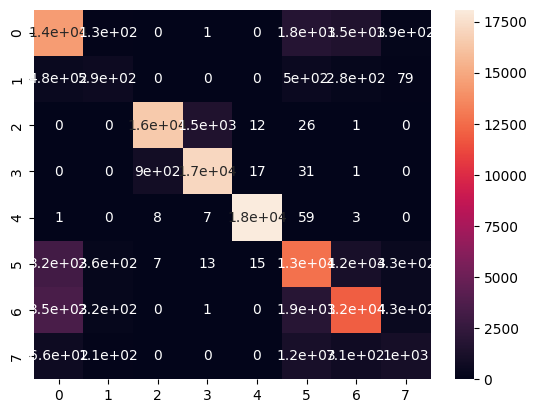

In [16]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [17]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [18]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, KNN_time]
results_dict["kNN"] = results

In [19]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.812612,0.811874,0.809292,0.812612,0.77933,0.688936,3.450591,1.857577,109.495392


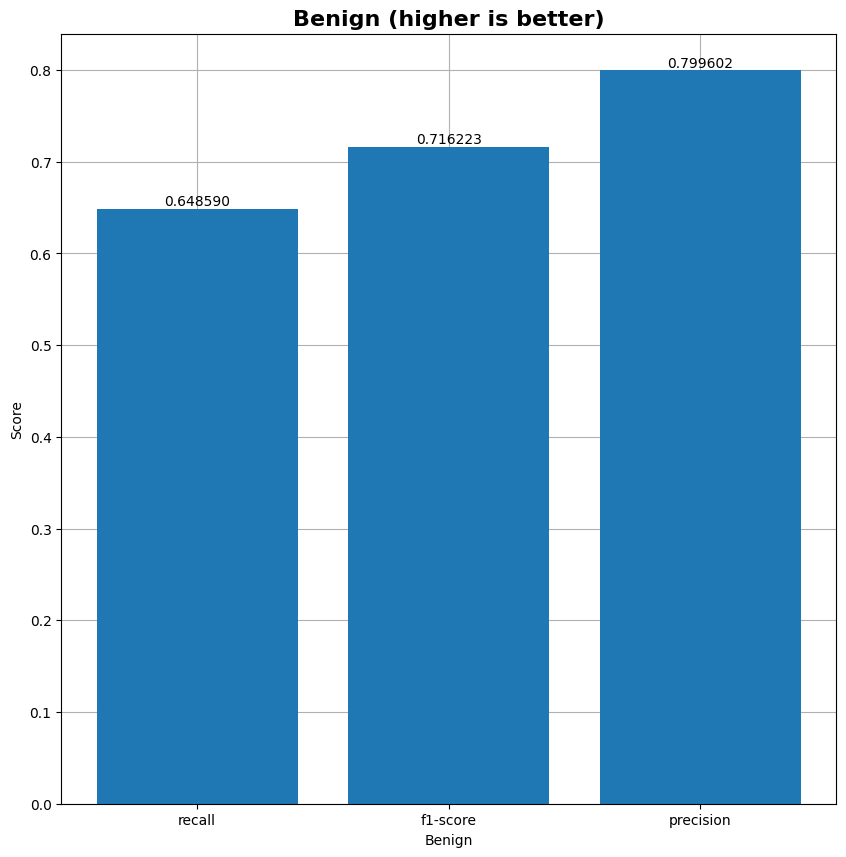

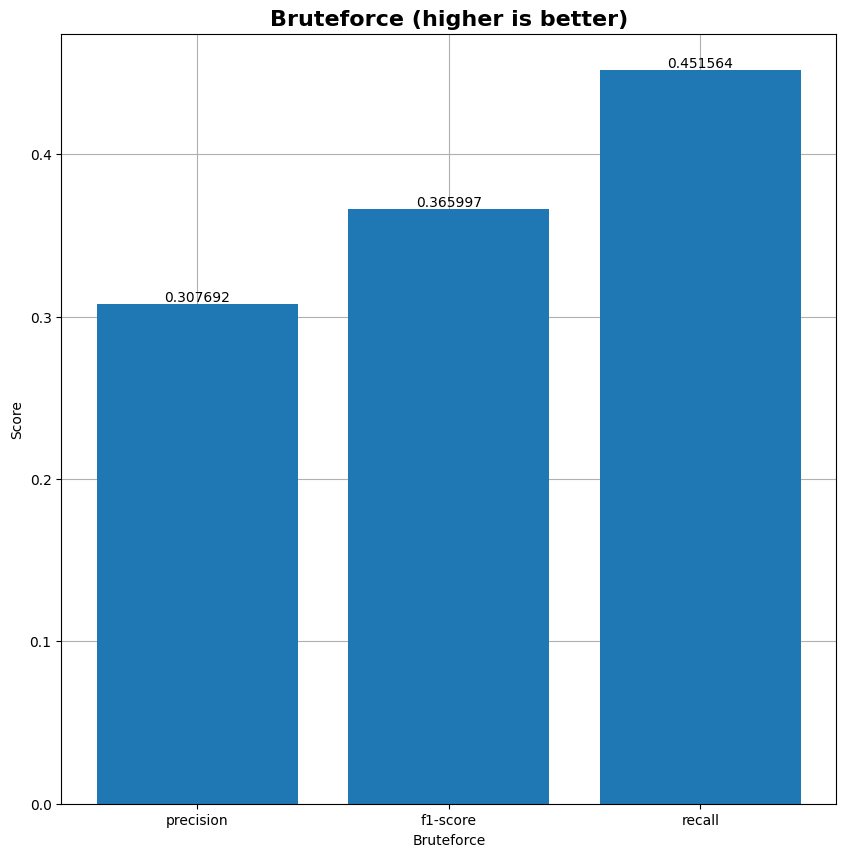

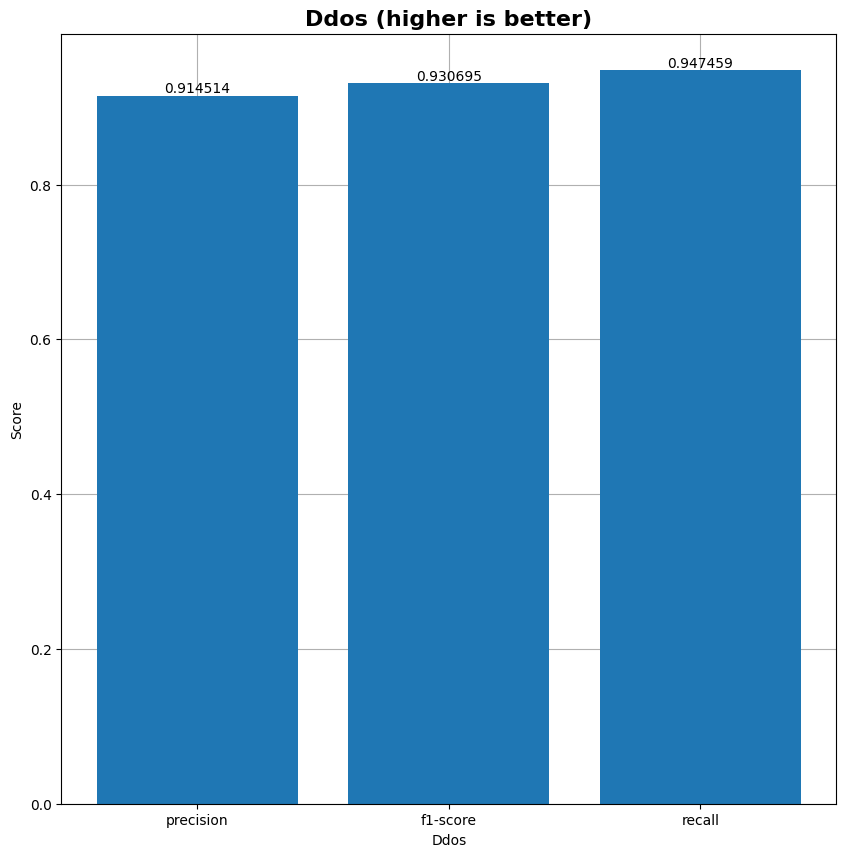

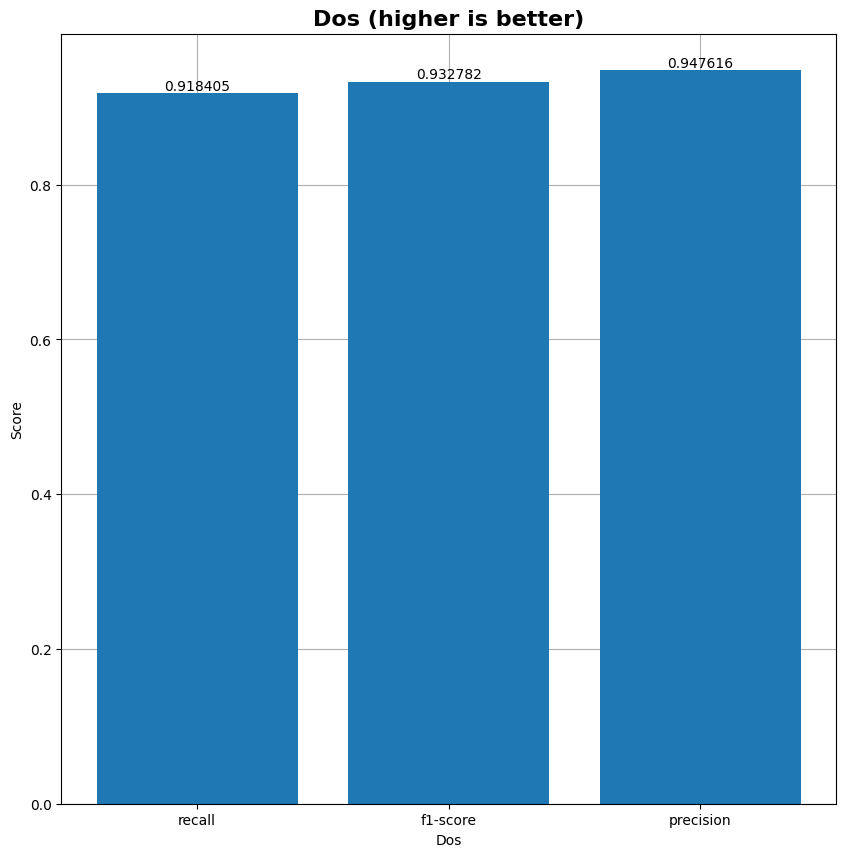

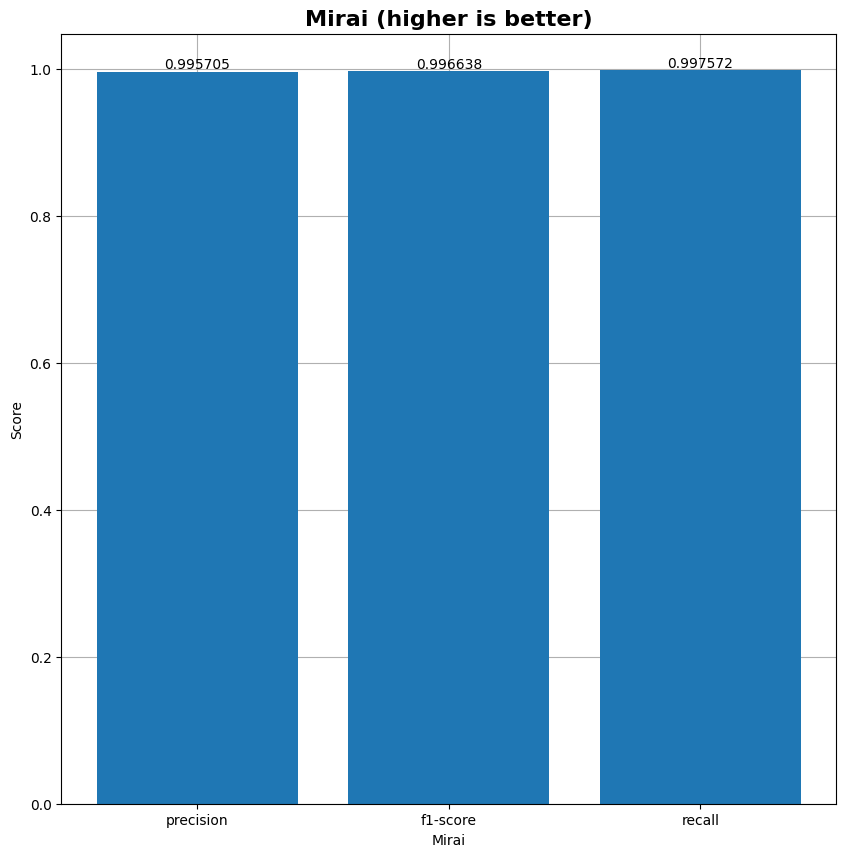

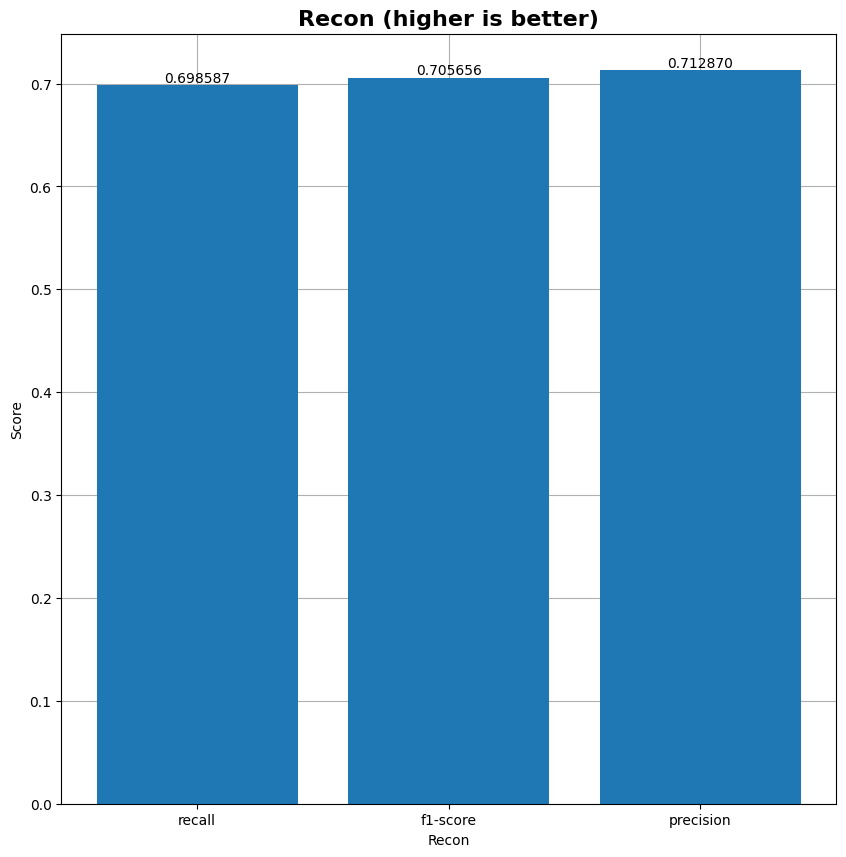

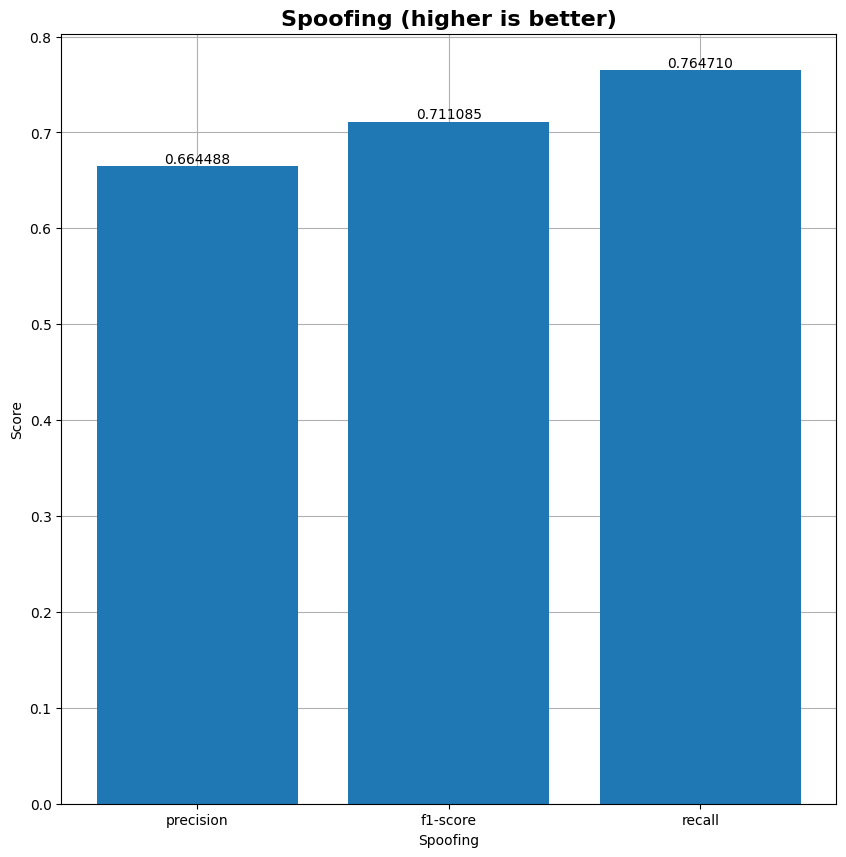

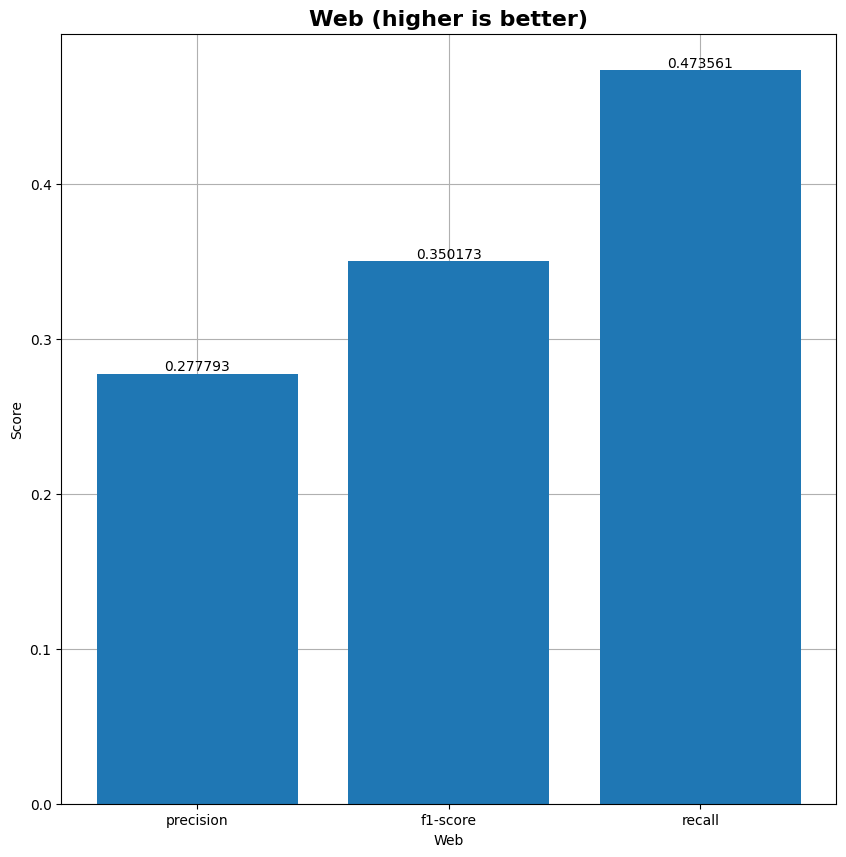

In [20]:
plot_mc(y_pred, y_test, "kNN")

# Random Forest

In [21]:
%%time

start = time.time()

rf_clf = RandomForestClassifier(n_jobs=8)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

end = time.time()

RF_time = end - start

CPU times: user 5min 32s, sys: 2.18 s, total: 5min 34s
Wall time: 51.9 s


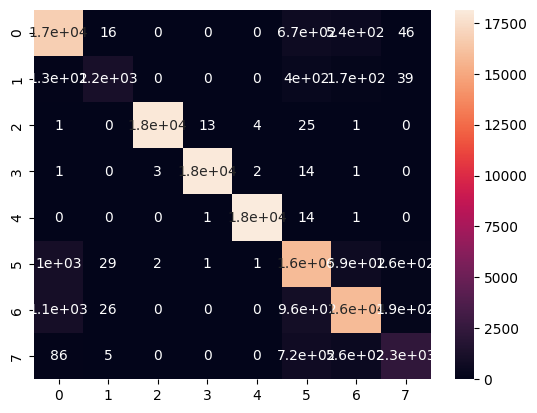

In [22]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [23]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [24]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, RF_time]
results_dict["RF"] = results

In [25]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.812612,0.811874,0.809292,0.812612,0.779330,0.688936,3.450591,1.857577,109.495392
RF,0.933078,0.933421,0.931983,0.933078,0.921043,0.232715,1.111713,1.054378,51.935459


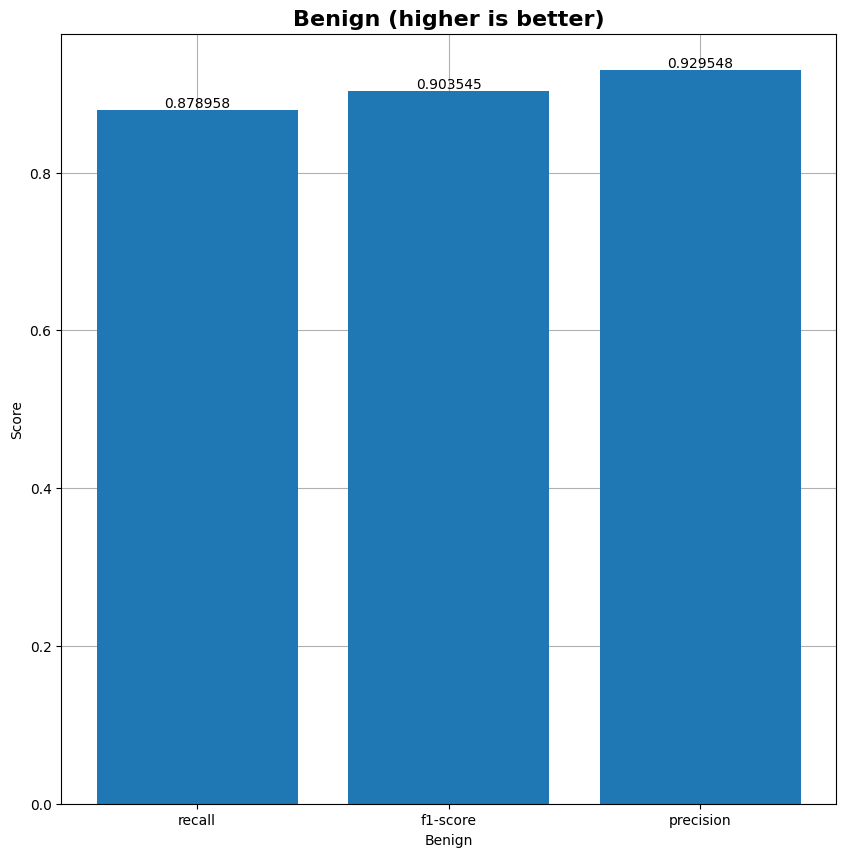

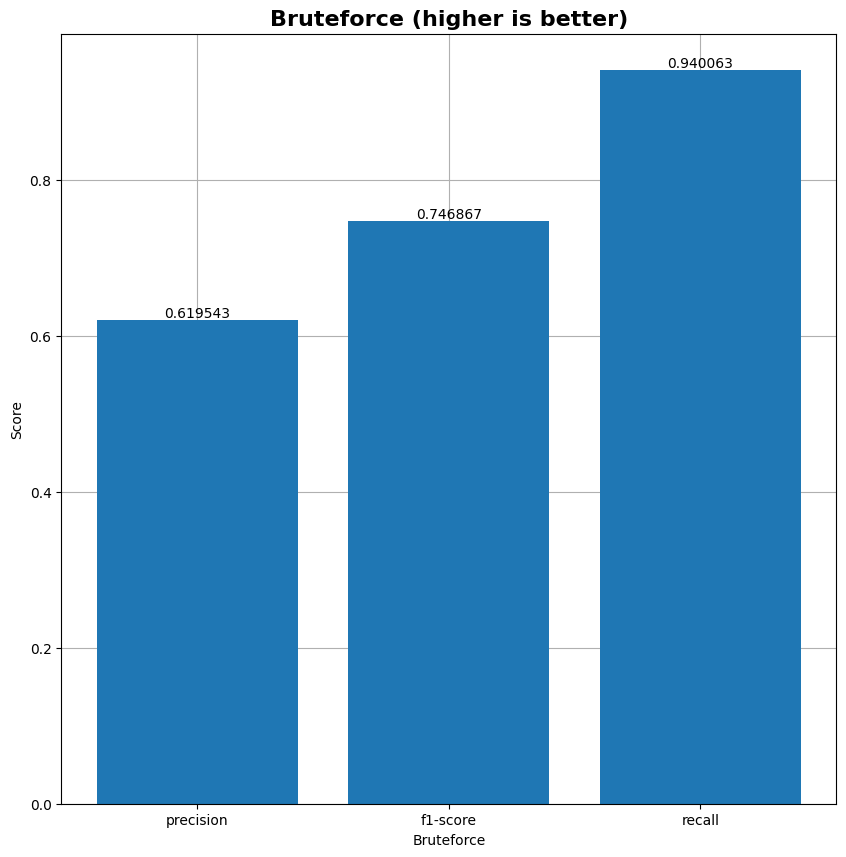

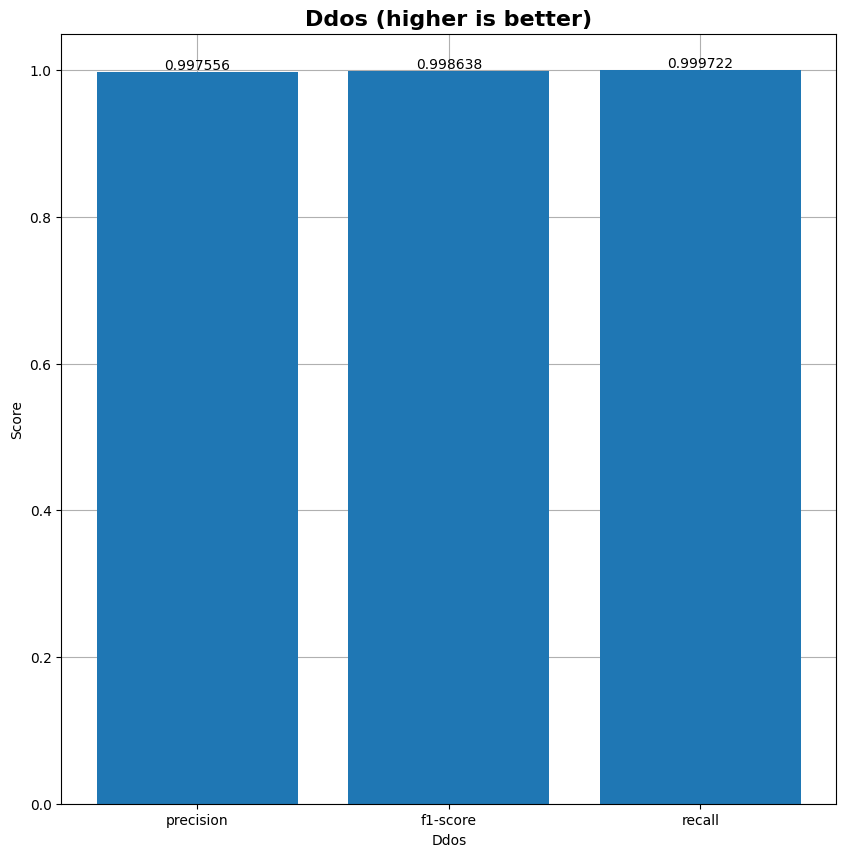

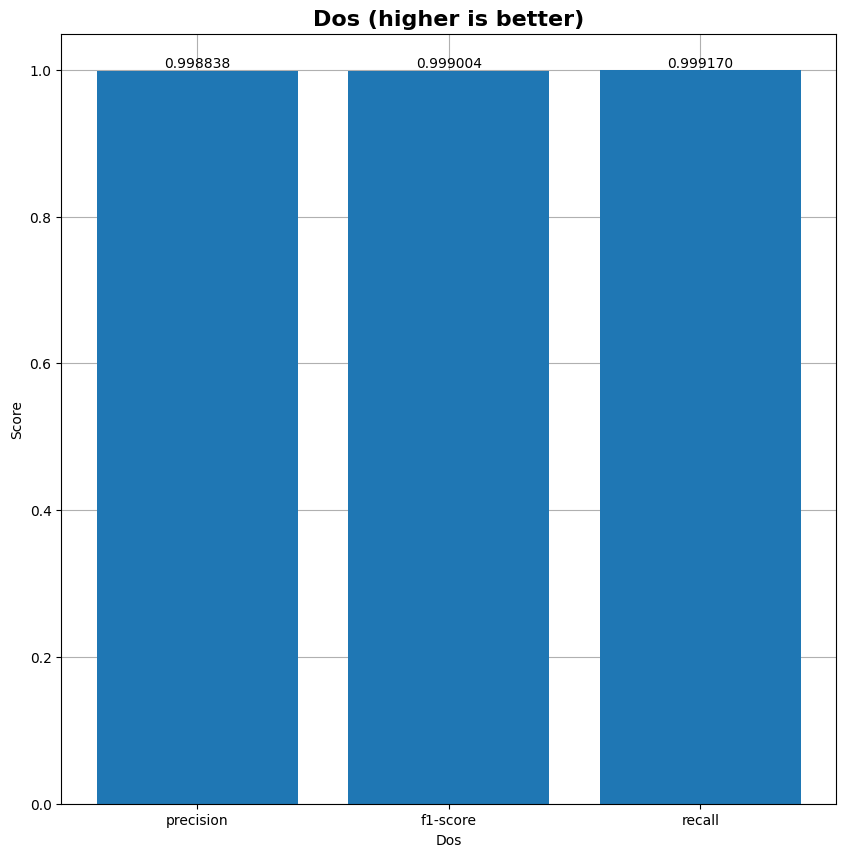

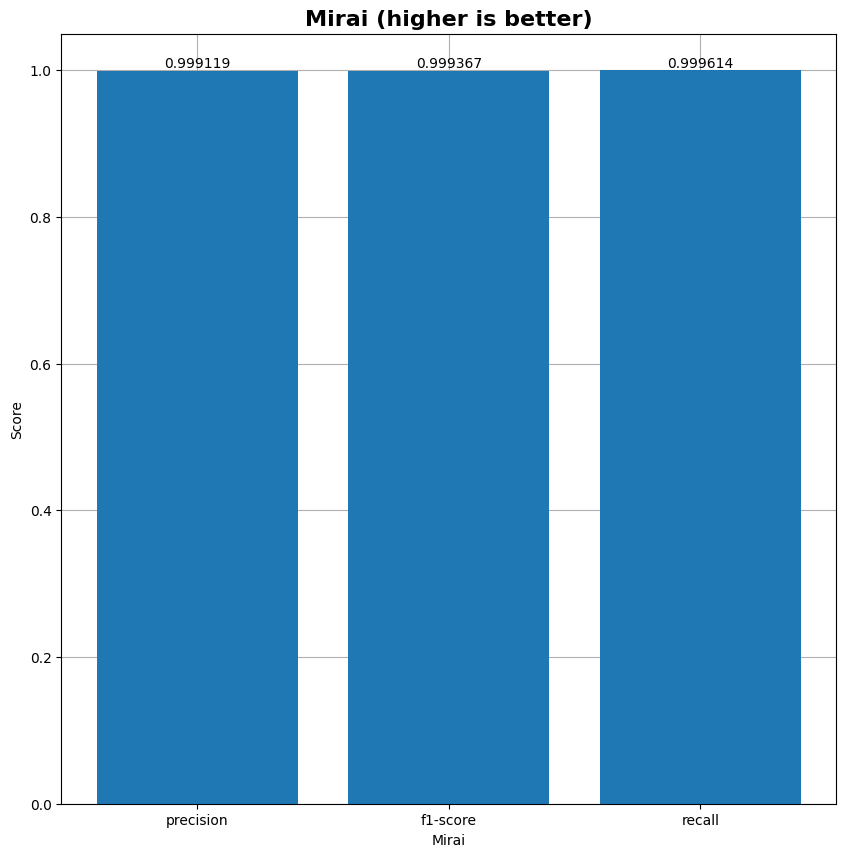

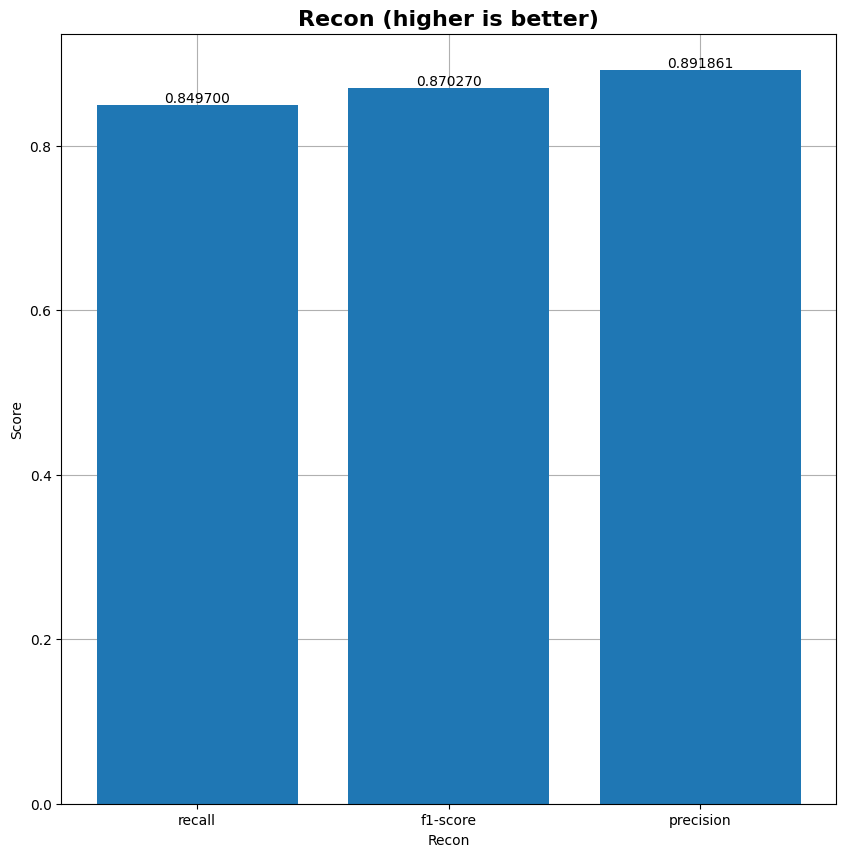

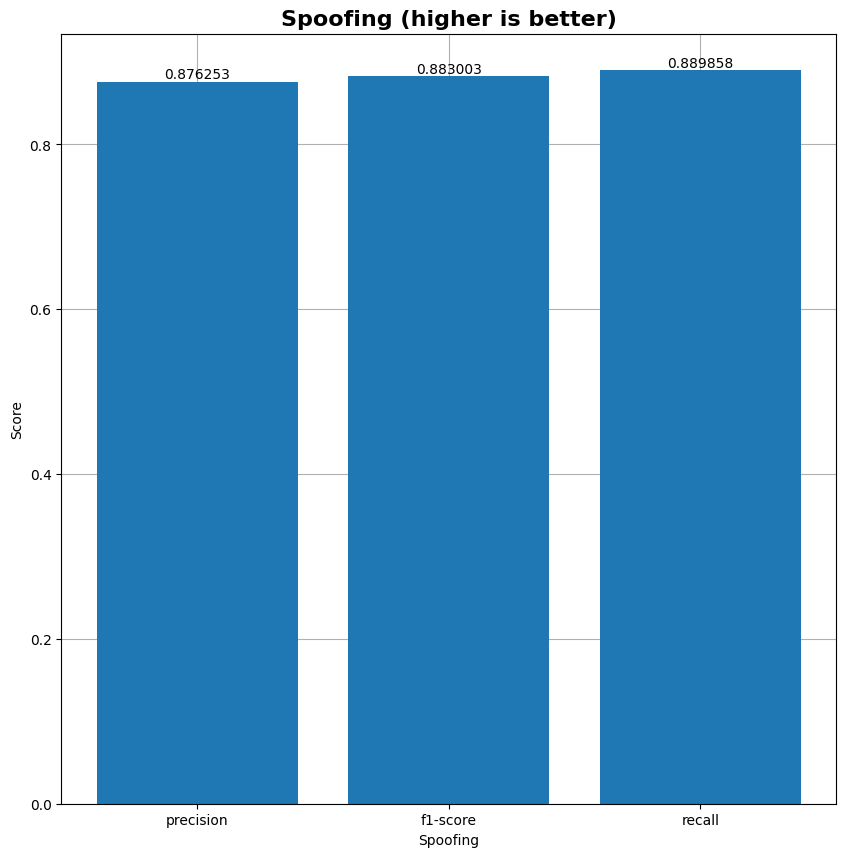

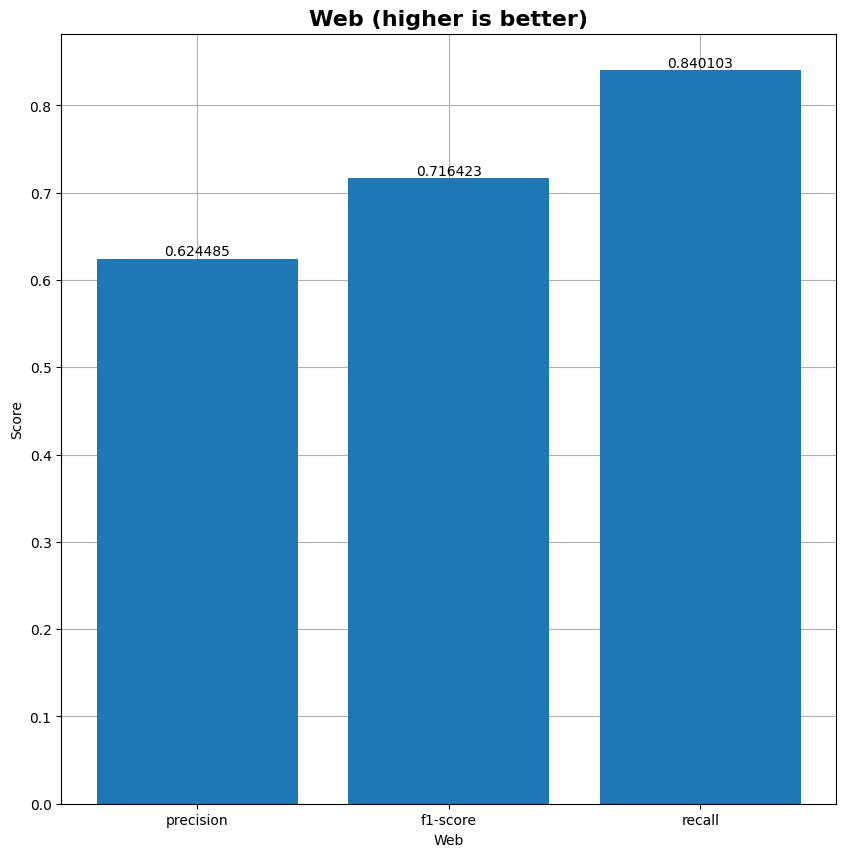

In [26]:
plot_mc(y_pred, y_test, "RF")

# XGBoost

In [27]:
%%time

start = time.time()

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

end = time.time()

XGB_time = end - start

CPU times: user 3min 53s, sys: 640 ms, total: 3min 53s
Wall time: 32.2 s


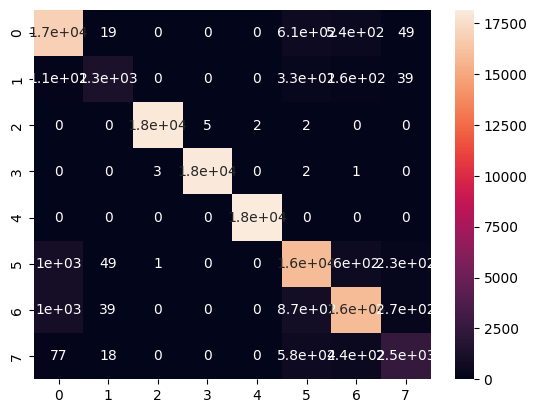

In [28]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [29]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [30]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, XGB_time]
results_dict["XGBoost"] = results

In [31]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.812612,0.811874,0.809292,0.812612,0.779330,0.688936,3.450591,1.857577,109.495392
RF,0.933078,0.933421,0.931983,0.933078,0.921043,0.232715,1.111713,1.054378,51.935459
XGBoost,0.937379,0.937320,0.936722,0.937379,0.926133,0.223154,1.079774,1.039122,32.162822


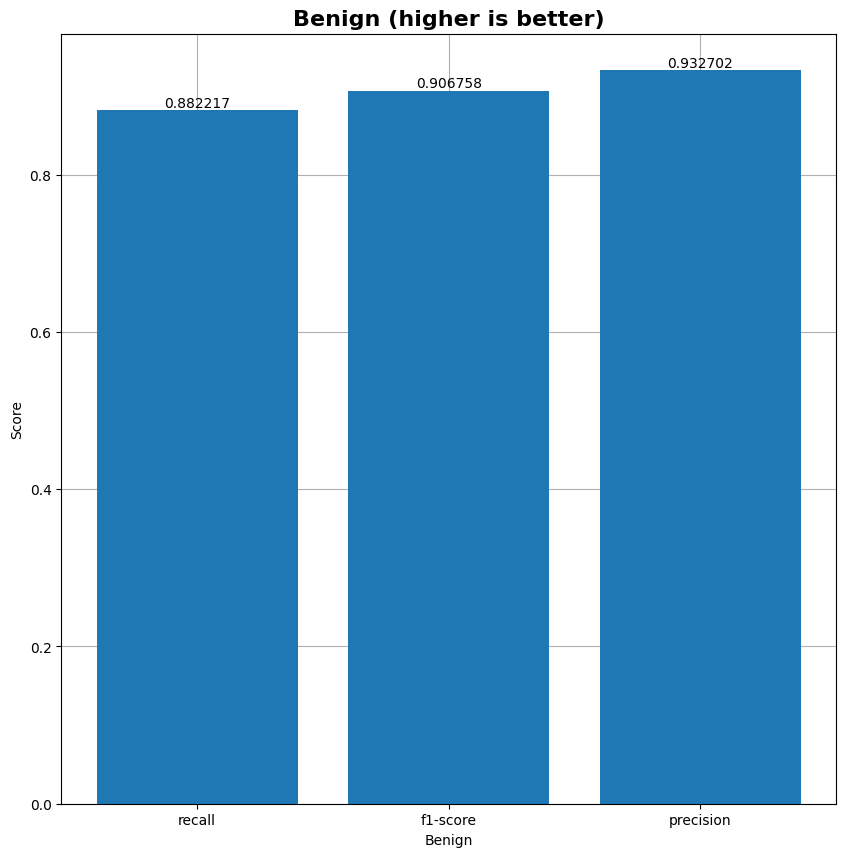

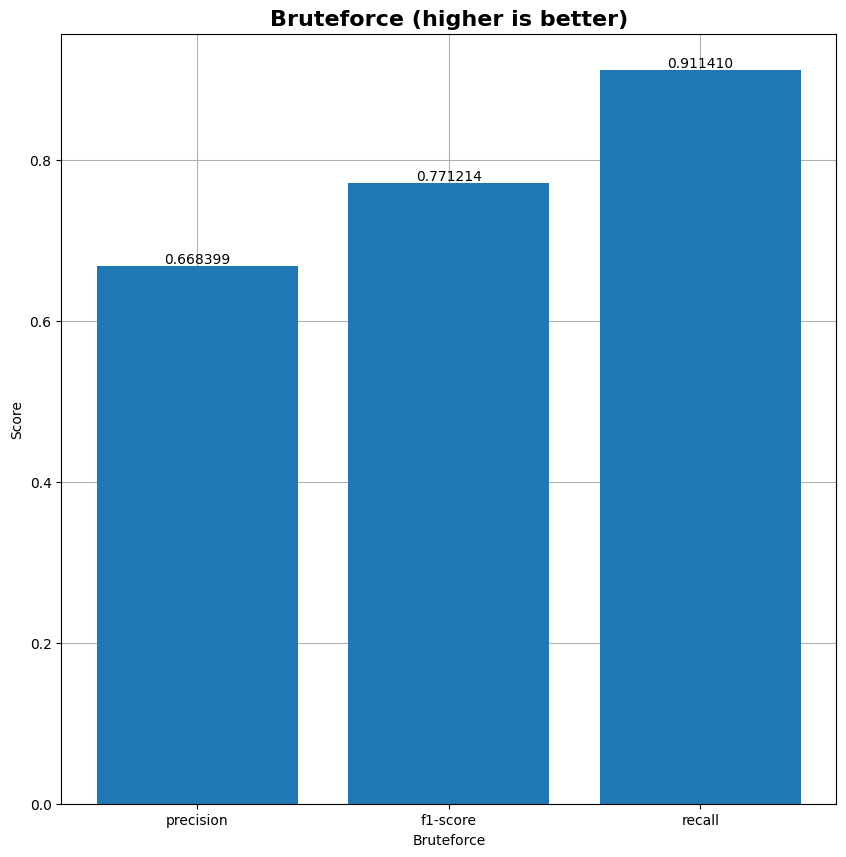

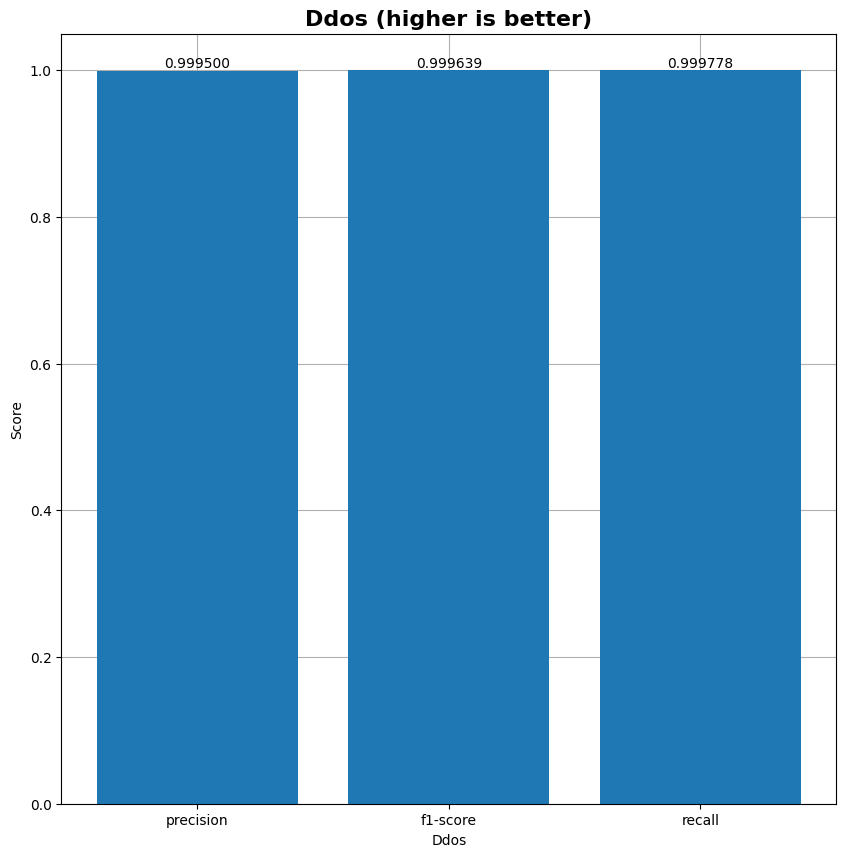

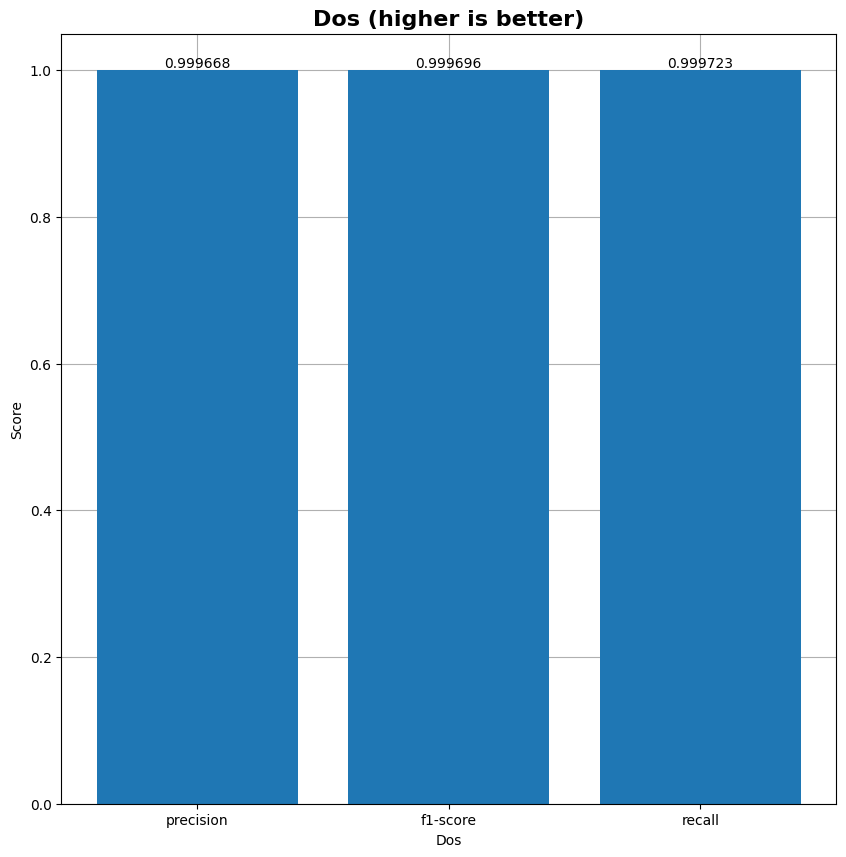

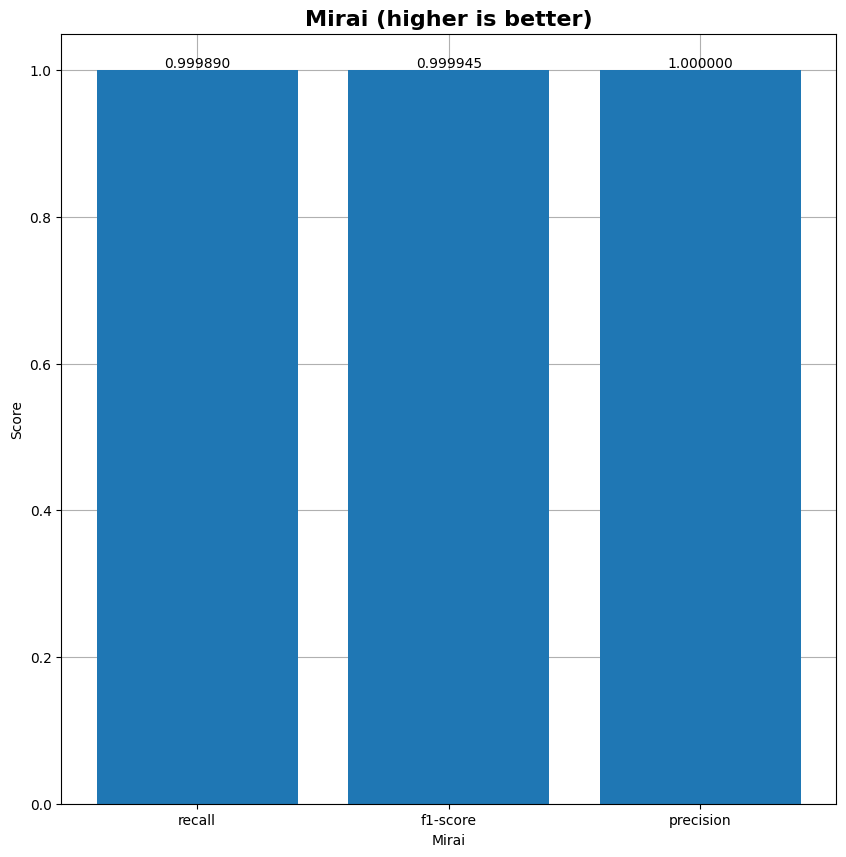

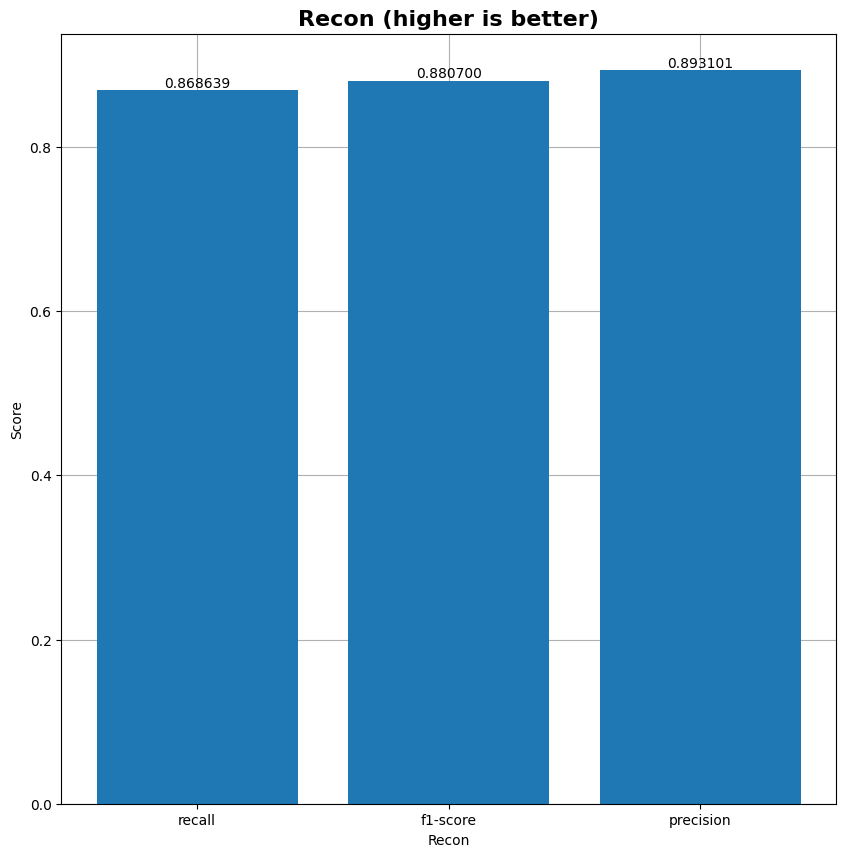

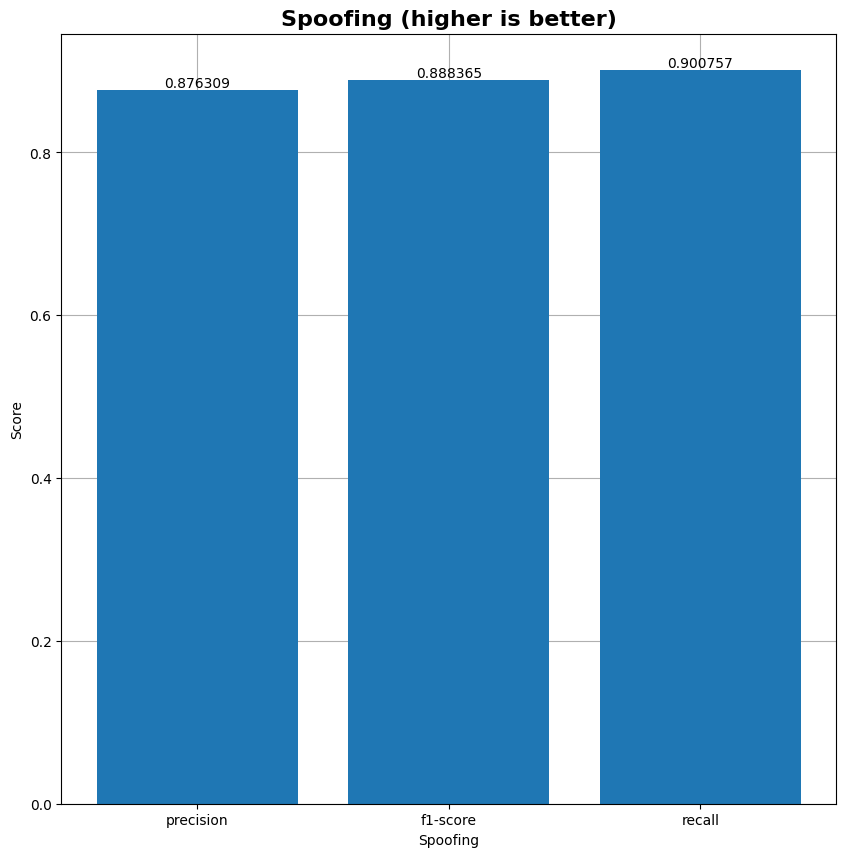

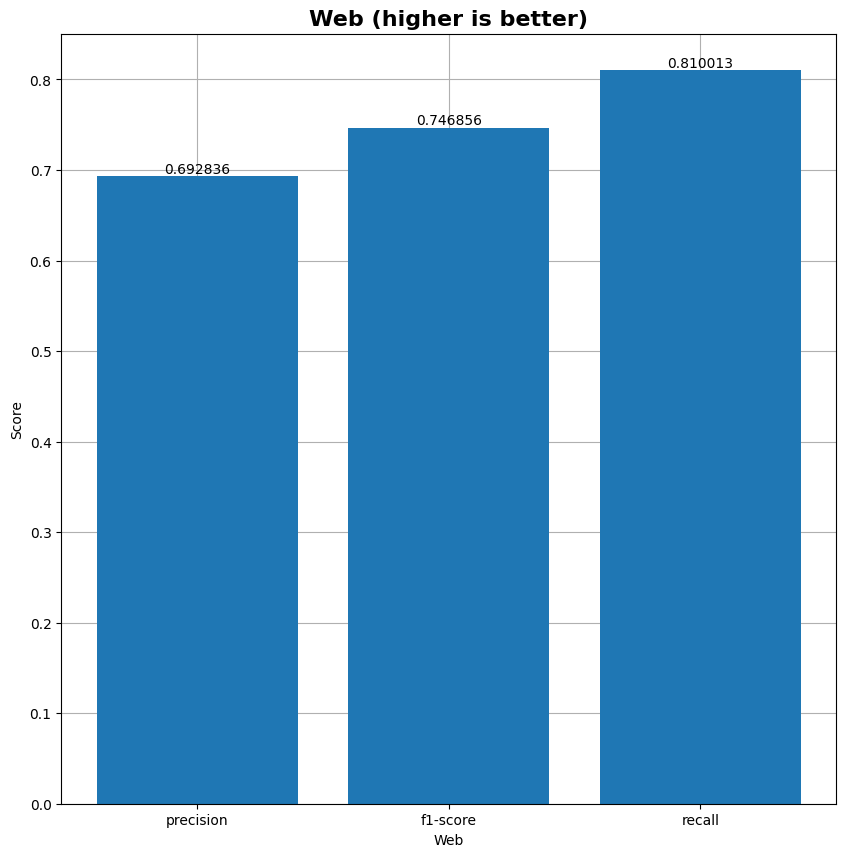

In [32]:
plot_mc(y_pred, y_test, "XGBoost")

# LightGBM

In [33]:
%%time

start = time.time()

lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)

end = time.time()

LightGBM_Time = end - start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5440
[LightGBM] [Info] Number of data points in the train set: 644209, number of used features: 40
[LightGBM] [Info] Start training from score -1.843727
[LightGBM] [Info] Start training from score -4.057481
[LightGBM] [Info] Start training from score -1.843080
[LightGBM] [Info] Start training from score -1.843815
[LightGBM] [Info] Start training from score -1.844610
[LightGBM] [Info] Start training from score -1.840651
[LightGBM] [Info] Start training from score -1.843570
[LightGBM] [Info] Start training from score -3.414683


/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


CPU times: user 1min 27s, sys: 223 ms, total: 1min 27s
Wall time: 22.4 s


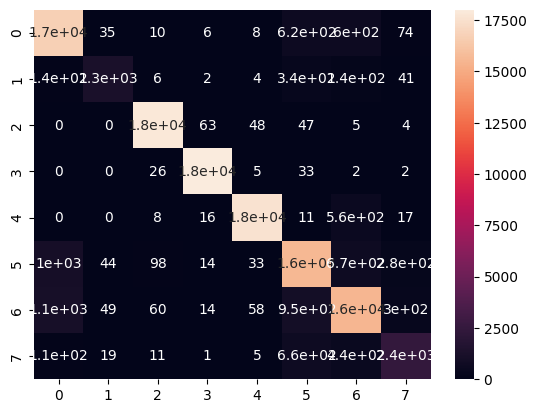

In [34]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [35]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [36]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LightGBM_Time]
results_dict["LightGBM"] = results

In [37]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.812612,0.811874,0.809292,0.812612,0.779330,0.688936,3.450591,1.857577,109.495392
RF,0.933078,0.933421,0.931983,0.933078,0.921043,0.232715,1.111713,1.054378,51.935459
XGBoost,0.937379,0.937320,0.936722,0.937379,0.926133,0.223154,1.079774,1.039122,32.162822
LightGBM,0.922232,0.922265,0.921616,0.922232,0.908239,0.261127,1.212220,1.101009,22.379797


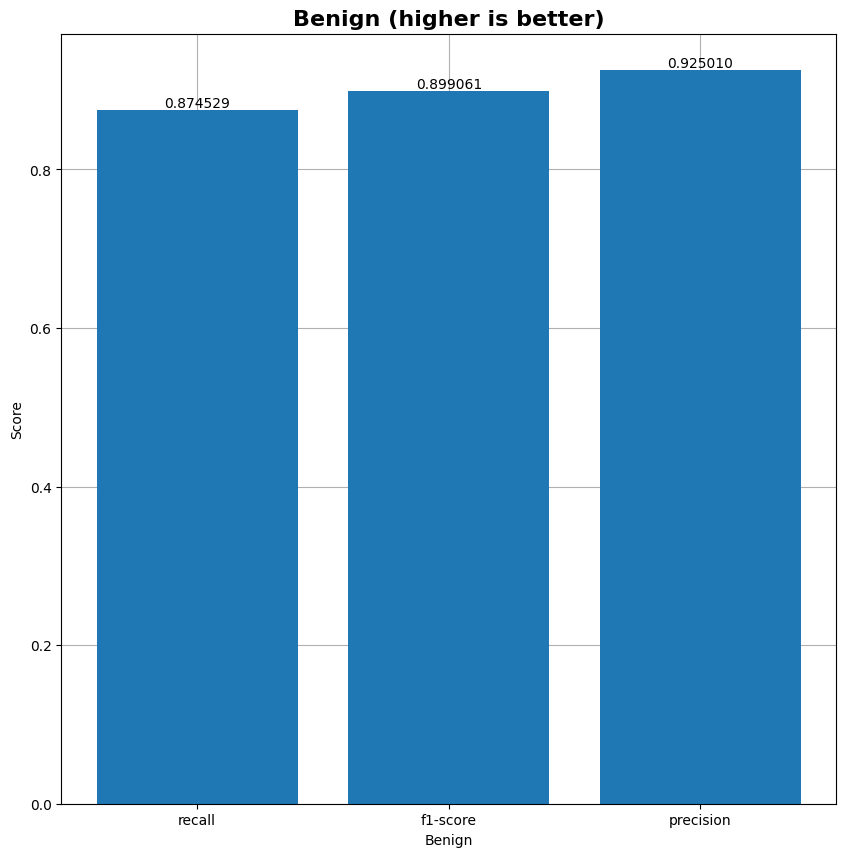

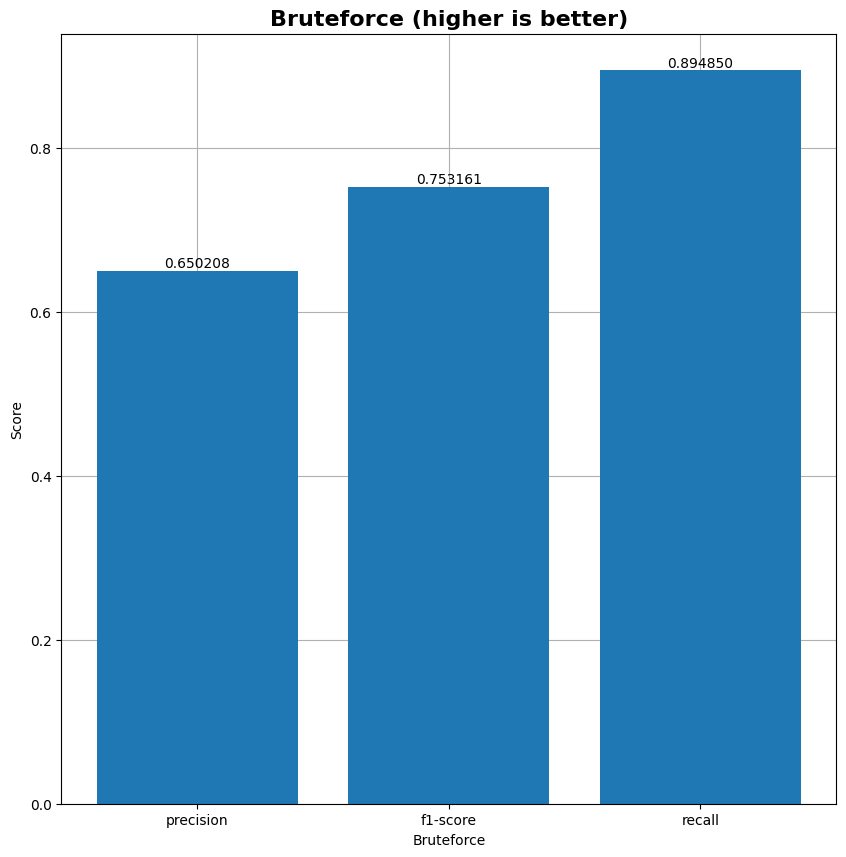

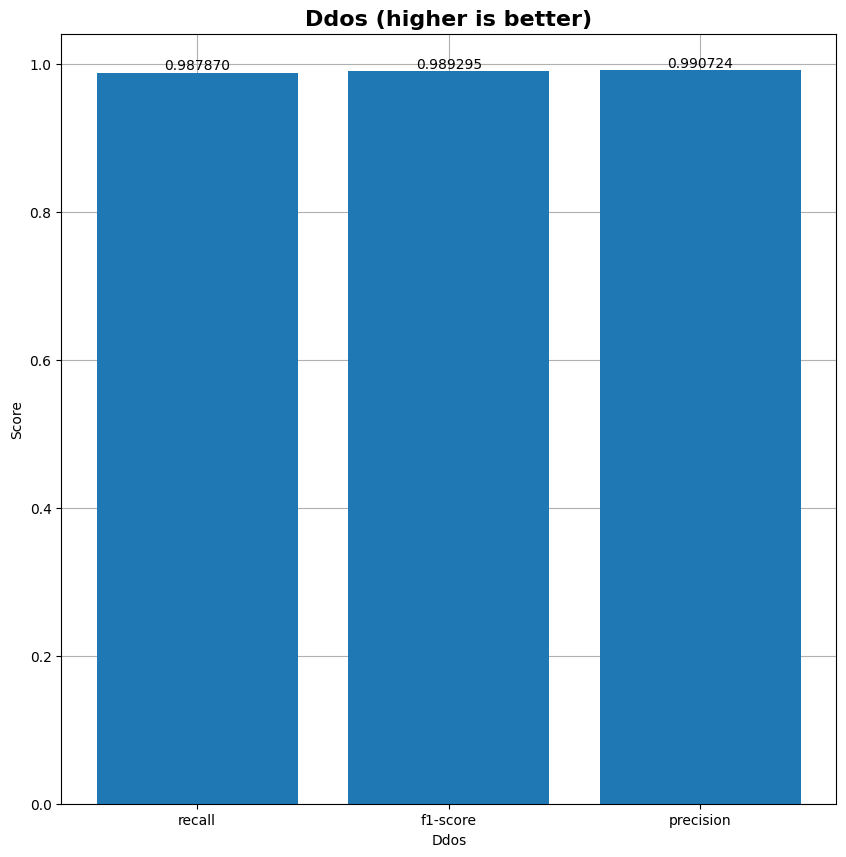

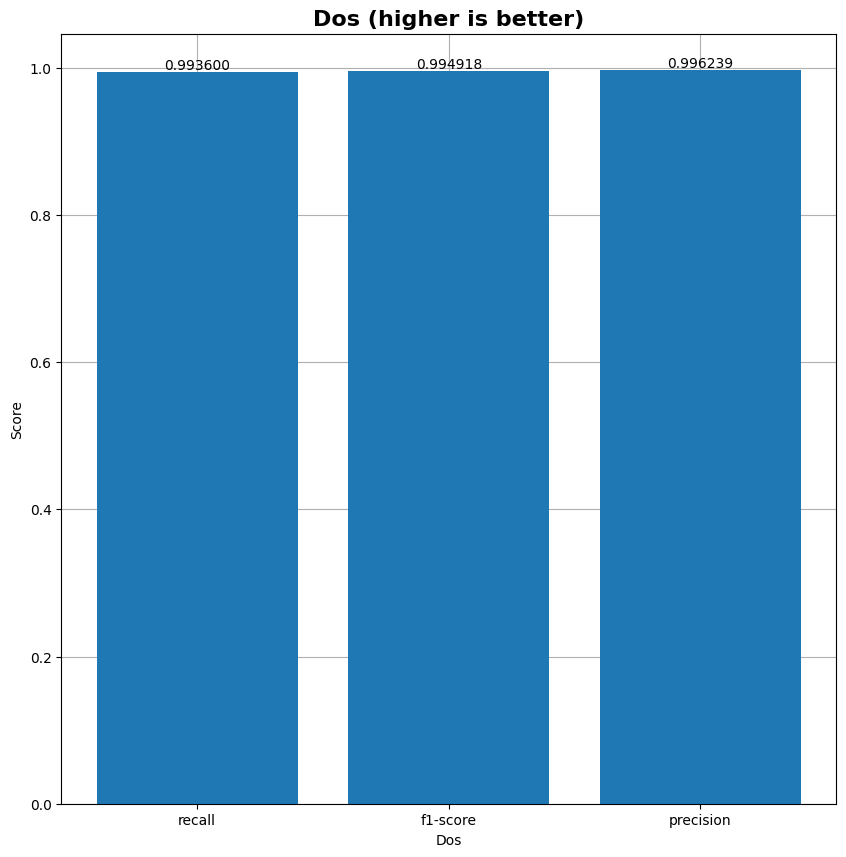

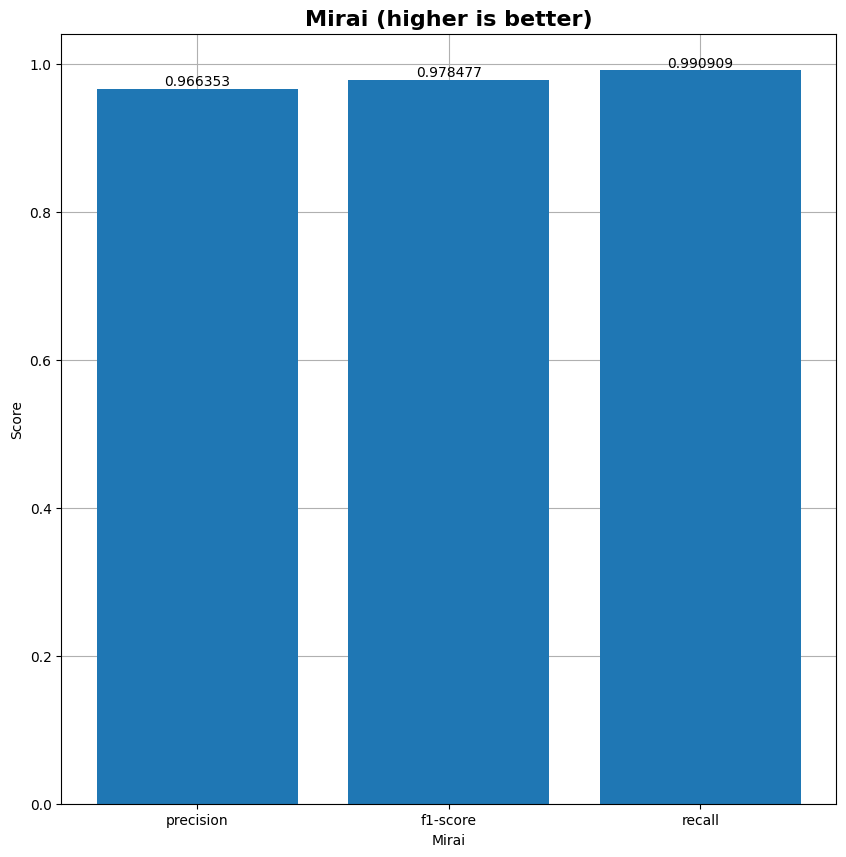

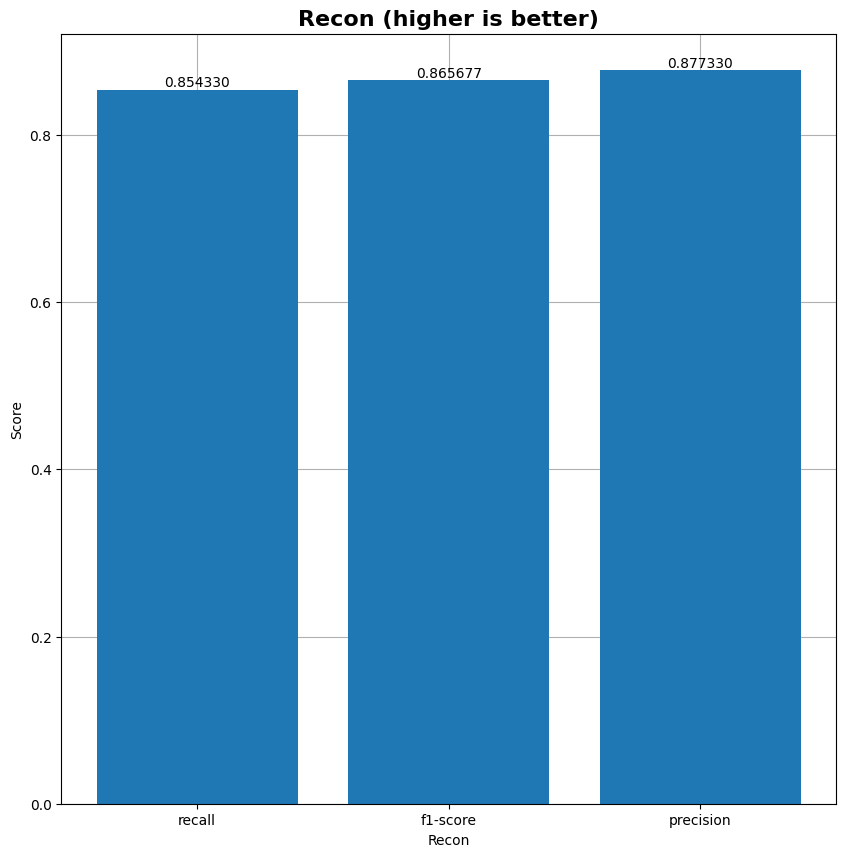

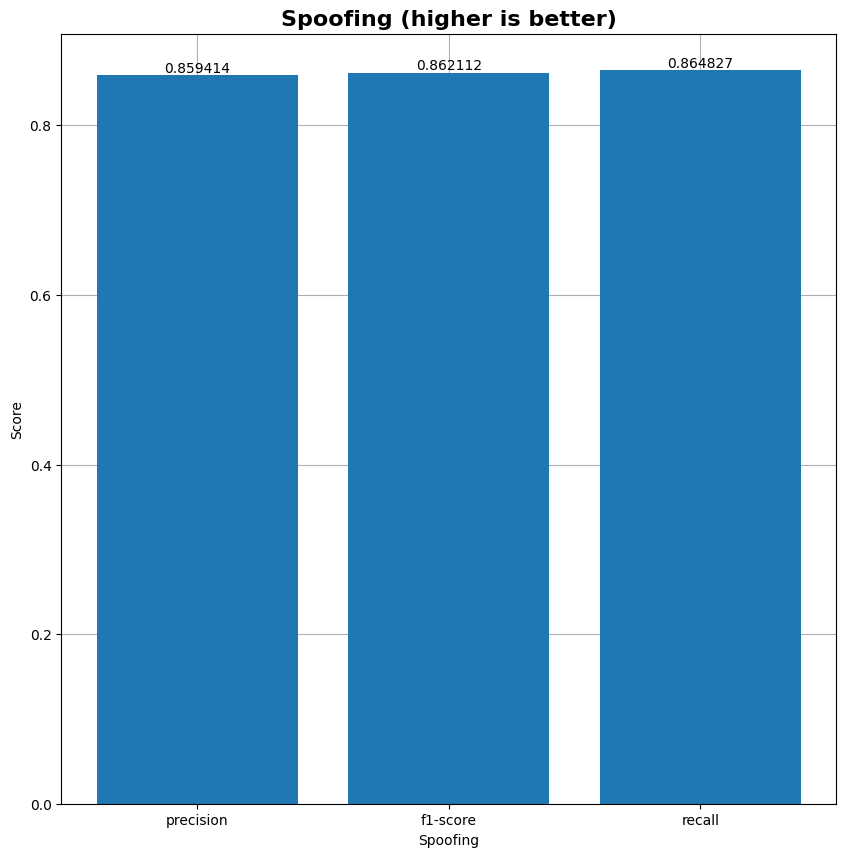

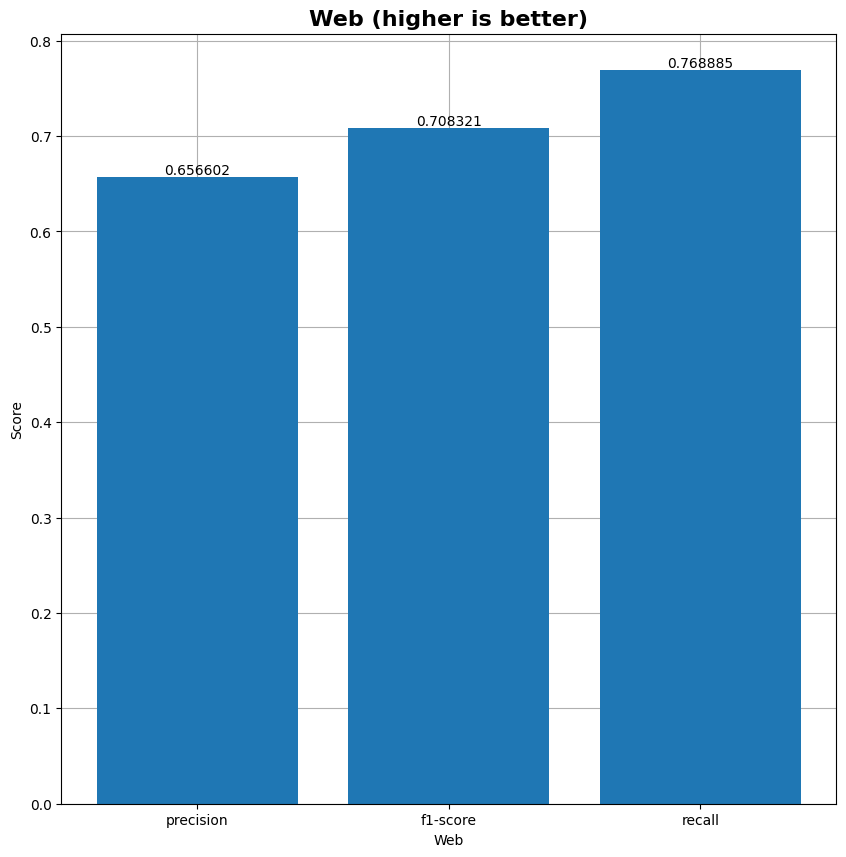

In [38]:
plot_mc(y_pred, y_test, "LightGBM")

# Feed Forward Neural Network

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((528251, 46), (528251,), (115958, 46), (115958,), (113684, 46), (113684,))

In [40]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(X_train, y_train)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744185071.588535   12607 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5114 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1


In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │        48,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 579,194 (2.21 MB)

 Trainable params: 579,194 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
%%time

start = time.time()

model.fit(X_train, y_train,
          batch_size=16,
          epochs=20,
          validation_data=(X_val, y_val))
gc.collect();

y_pred = model.predict(X_test)

end = time.time()

FFNN_Time = end - start

Epoch 1/20


I0000 00:00:1744185073.726221   17361 service.cc:152] XLA service 0x7eb3ac00b750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744185073.726238   17361 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2025-04-09 10:51:13.761501: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744185073.993634   17361 cuda_dnn.cc:529] Loaded cuDNN version 90300


   69/33016 ━━━━━━━━━━━━━━━━━━━━ 1:14 2ms/step - accuracy: 0.5381 - loss: 1.3311       

I0000 00:00:1744185075.014239   17361 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33016/33016 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - accuracy: 0.7465 - loss: 0.5943 - val_accuracy: 0.7747 - val_loss: 0.5159
Epoch 2/20
33016/33016 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - accuracy: 0.7849 - loss: 0.4997 - val_accuracy: 0.7924 - val_loss: 0.4837
Epoch 3/20
33016/33016 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - accuracy: 0.7903 - loss: 0.4858 - val_accuracy: 0.7894 - val_loss: 0.4799
Epoch 4/20
33016/33016 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - accuracy: 0.7937 - loss: 0.5476 - val_accuracy: 0.7967 - val_loss: 0.4790
Epoch 5/20
33016/33016 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - accuracy: 0.7949 - loss: 0.4755 - val_accuracy: 0.7955 - val_loss: 0.4718
Epoch 6/20
33016/33016 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - accuracy: 0.7947 - loss: 0.4792 - val_accuracy: 0.8000 - val_loss: 0.4649
Epoch 7/20
33016/33016 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - accuracy: 0.7976 - loss: 1.2698 - val_accuracy: 0.7962 - val_loss: 0.4806
Epoch 8/20
33016/33016 ━━━━━━━━━━━━━━━━━━━━ 89s 3ms/step - accuracy: 0.7965 - lo

In [43]:
y_pred = np.argmax(y_pred, axis=1)

In [44]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

3553/3553 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8055 - loss: 0.4606


In [45]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, FFNN_Time]
results_dict["FF-NN"] = results

In [46]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.812612,0.811874,0.809292,0.812612,0.779330,0.688936,3.450591,1.857577,109.495392
RF,0.933078,0.933421,0.931983,0.933078,0.921043,0.232715,1.111713,1.054378,51.935459
XGBoost,0.937379,0.937320,0.936722,0.937379,0.926133,0.223154,1.079774,1.039122,32.162822
LightGBM,0.922232,0.922265,0.921616,0.922232,0.908239,0.261127,1.212220,1.101009,22.379797
FF-NN,0.803939,0.806979,0.797755,0.803939,0.768943,0.539812,2.362619,1.537081,1622.258329


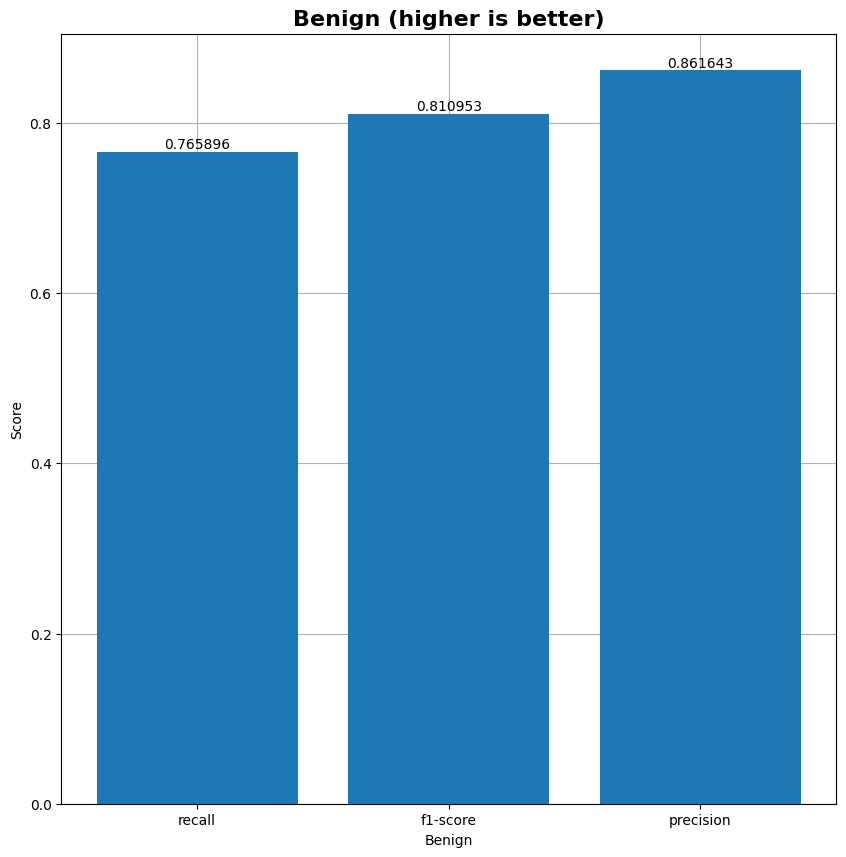

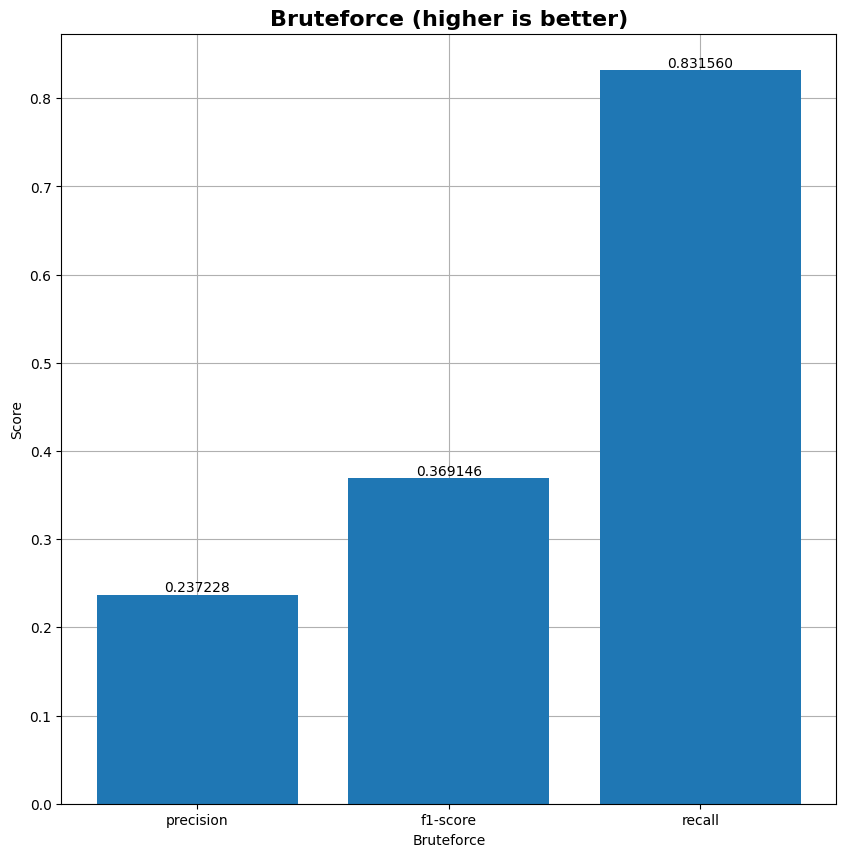

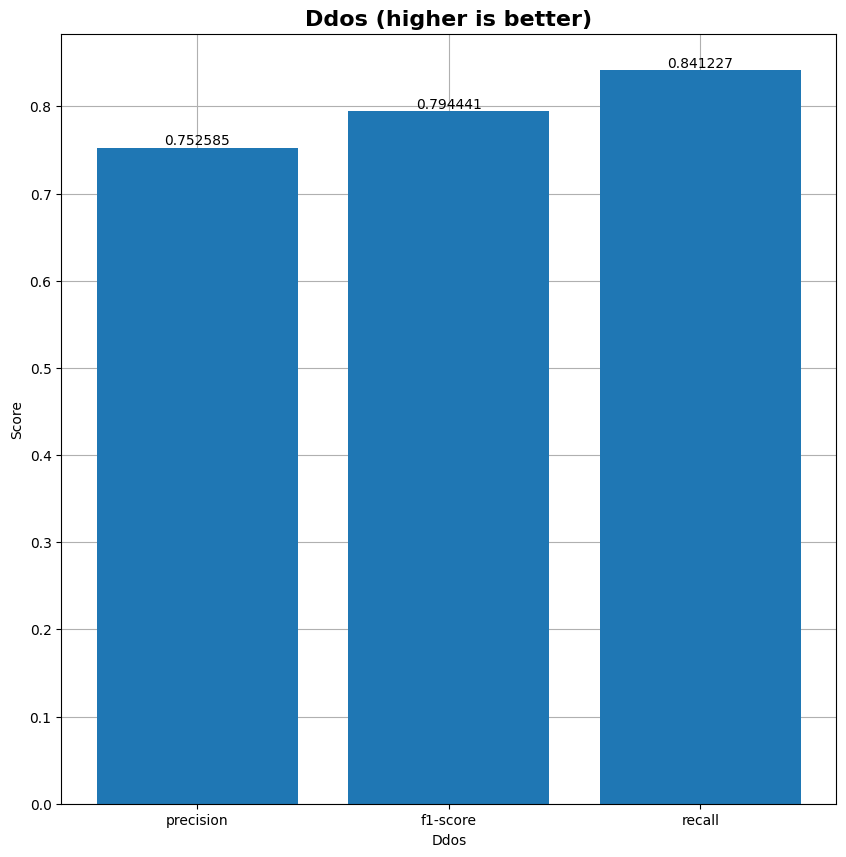

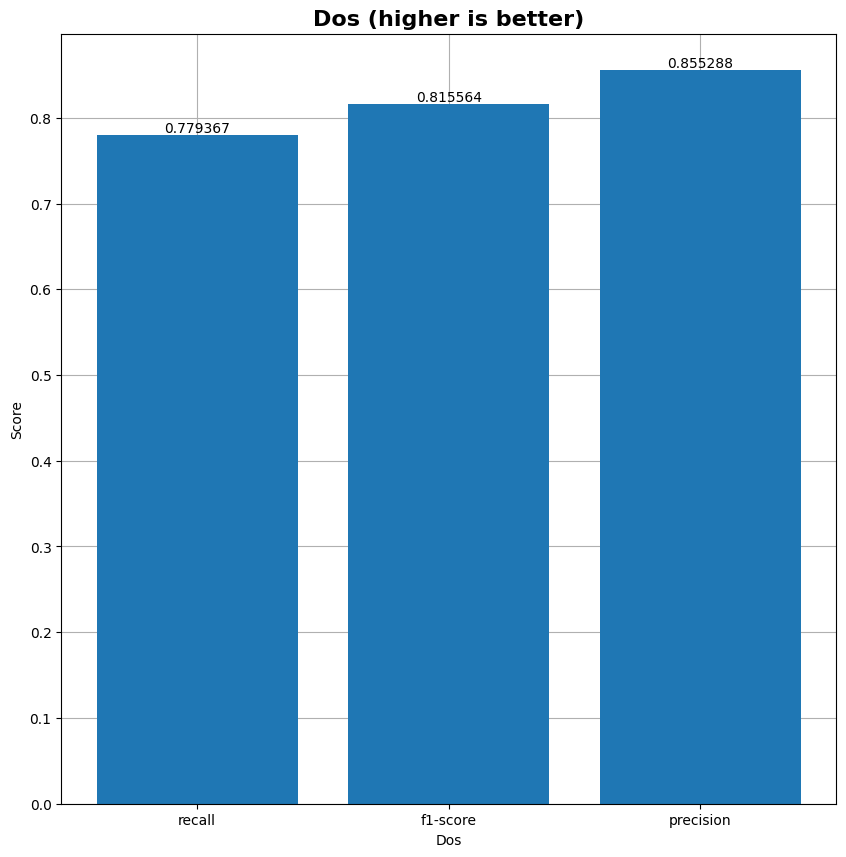

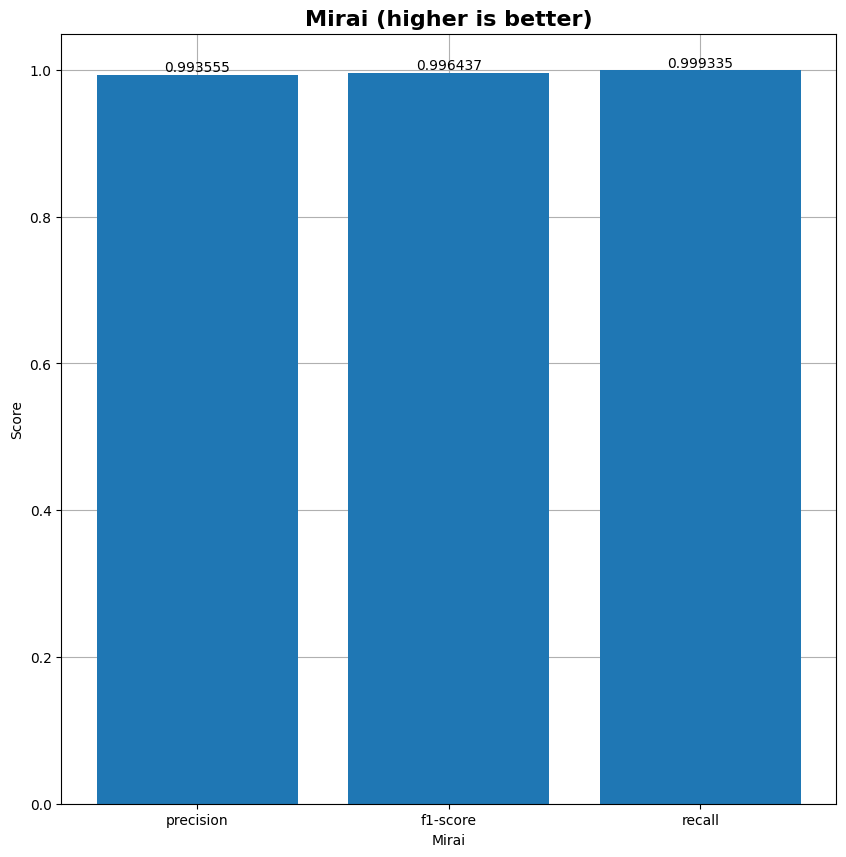

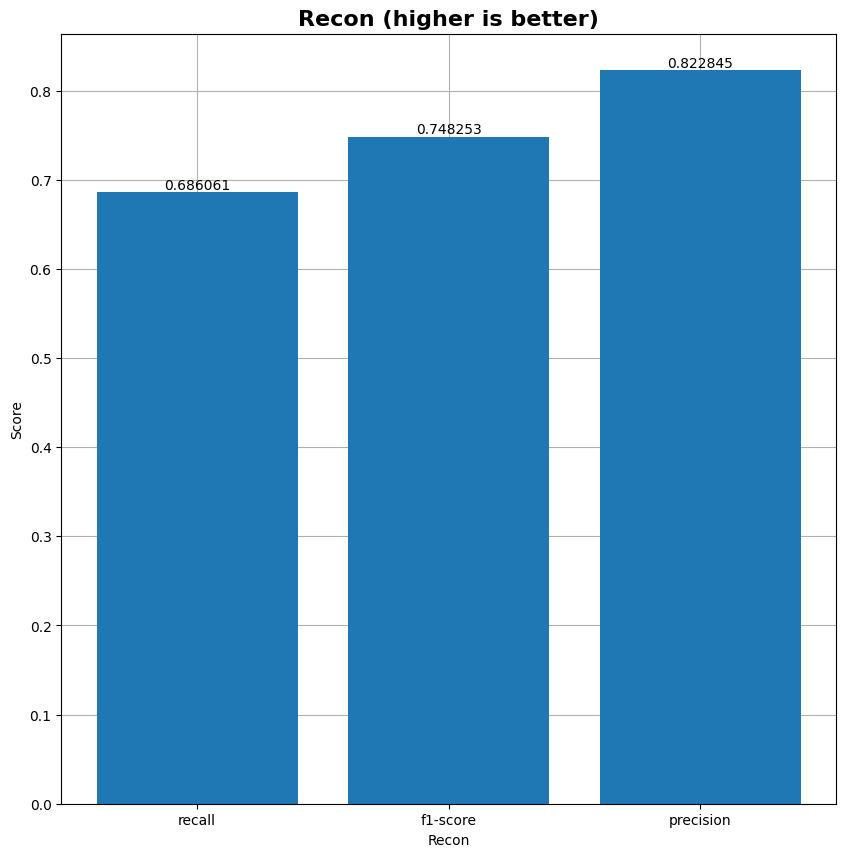

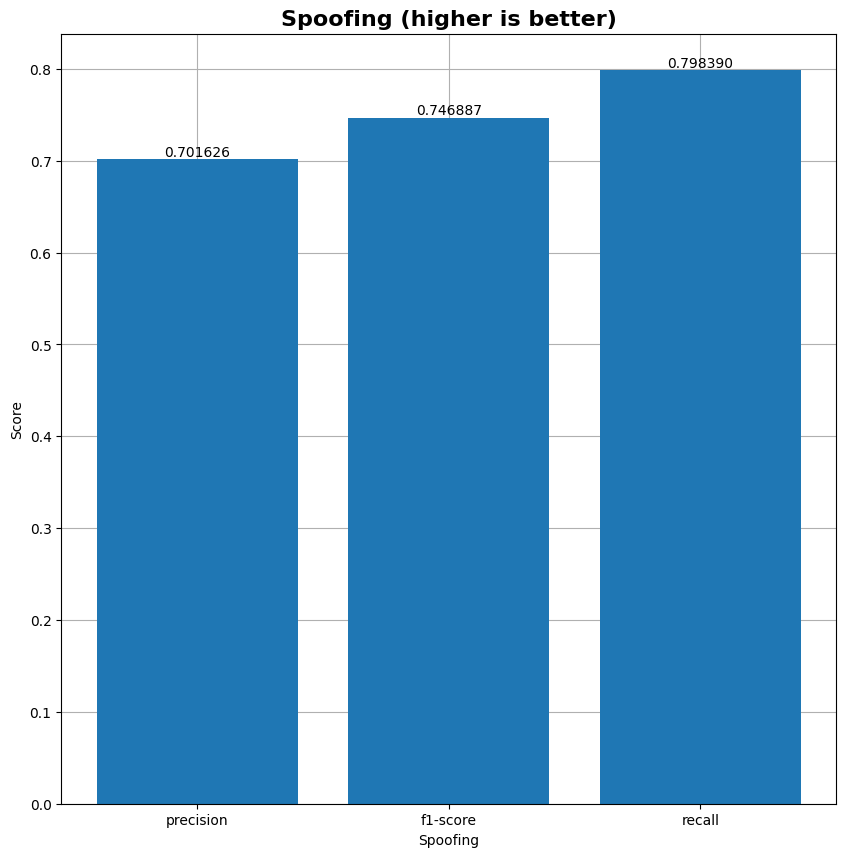

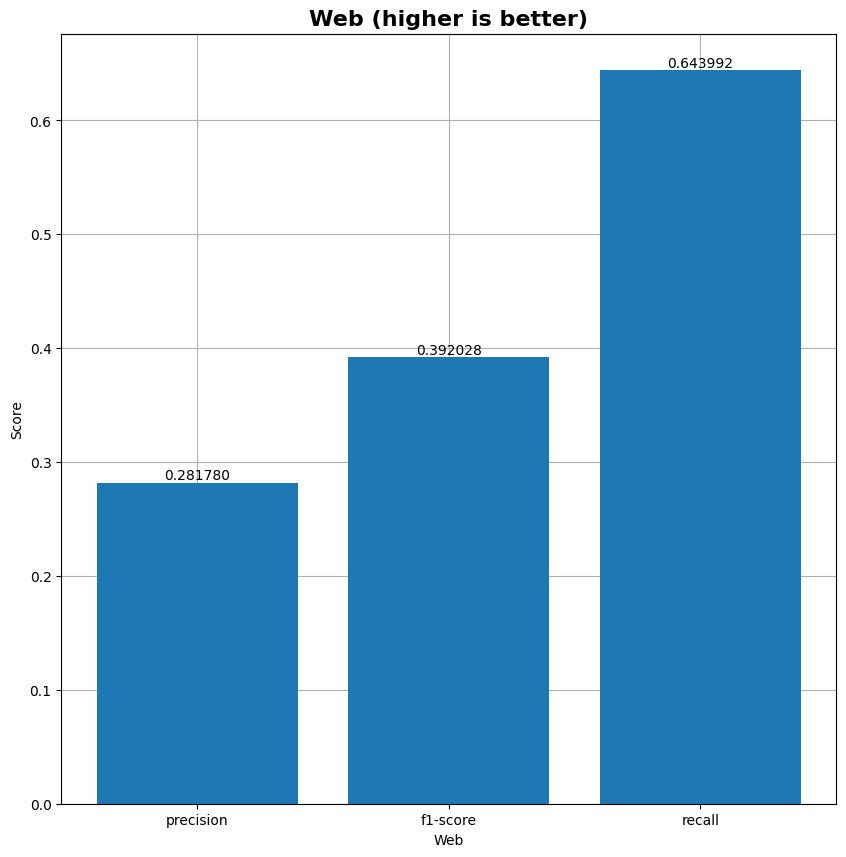

In [47]:
plot_mc(y_pred, y_test, "FF-NN")

# LSTM

In [48]:
# Prepare sequential data
def create_sequences(features, labels, seq_length):
    sequences, seq_labels = [], []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])  # Use the last label in the sequence
    return np.array(sequences), np.array(seq_labels)

In [49]:
num_components = len(np.unique(y))

In [50]:
# Create sequences
seq_length = 20
X1, y1 = create_sequences(X, y, seq_length)
y1 = to_categorical(y1, num_classes=num_components)  # Convert labels to one-hot encoding

In [51]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [52]:
def create_model_LSTM(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [53]:
# Build model
model = create_model_LSTM(input_shape=(seq_length, X1.shape[2]), num_classes=num_components)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [54]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        28,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,464 (169.78 KB)

 Trainable params: 43,464 (169.78 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
%%time

start = time.time()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate model
y_pred = model.predict(X_test)

end = time.time()

LSTM_Time = end - start

Epoch 1/10
16579/16579 ━━━━━━━━━━━━━━━━━━━━ 119s 7ms/step - accuracy: 0.9880 - loss: 0.0454 - val_accuracy: 0.9996 - val_loss: 0.0017
Epoch 2/10
16579/16579 ━━━━━━━━━━━━━━━━━━━━ 114s 7ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.9996 - val_loss: 0.0015
Epoch 3/10
16579/16579 ━━━━━━━━━━━━━━━━━━━━ 113s 7ms/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 0.9999 - val_loss: 7.4098e-04
Epoch 4/10
16579/16579 ━━━━━━━━━━━━━━━━━━━━ 114s 7ms/step - accuracy: 0.9998 - loss: 7.7748e-04 - val_accuracy: 0.9999 - val_loss: 8.9528e-04
Epoch 5/10
16579/16579 ━━━━━━━━━━━━━━━━━━━━ 121s 7ms/step - accuracy: 0.9998 - loss: 8.3435e-04 - val_accuracy: 1.0000 - val_loss: 3.3794e-04
Epoch 6/10
16579/16579 ━━━━━━━━━━━━━━━━━━━━ 119s 7ms/step - accuracy: 0.9999 - loss: 8.4729e-04 - val_accuracy: 0.9999 - val_loss: 8.5964e-04
Epoch 7/10
16579/16579 ━━━━━━━━━━━━━━━━━━━━ 120s 7ms/step - accuracy: 0.9999 - loss: 4.6595e-04 - val_accuracy: 0.9999 - val_loss: 9.2231e-04
Epoch 8/10
16579/16579 ━━━

In [56]:
_, accuracy = model.evaluate(X_test, y_test)

3553/3553 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 1.0000 - loss: 1.7078e-04


In [57]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [58]:
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [59]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LSTM_Time]
results_dict["LSTM"] = results

In [60]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.812612,0.811874,0.809292,0.812612,0.779330,0.688936,3.450591,1.857577,109.495392
RF,0.933078,0.933421,0.931983,0.933078,0.921043,0.232715,1.111713,1.054378,51.935459
XGBoost,0.937379,0.937320,0.936722,0.937379,0.926133,0.223154,1.079774,1.039122,32.162822
LightGBM,0.922232,0.922265,0.921616,0.922232,0.908239,0.261127,1.212220,1.101009,22.379797
FF-NN,0.803939,0.806979,0.797755,0.803939,0.768943,0.539812,2.362619,1.537081,1622.258329
LSTM,0.999965,0.999965,0.999965,0.999965,0.999959,0.000185,0.000994,0.031528,1215.398477


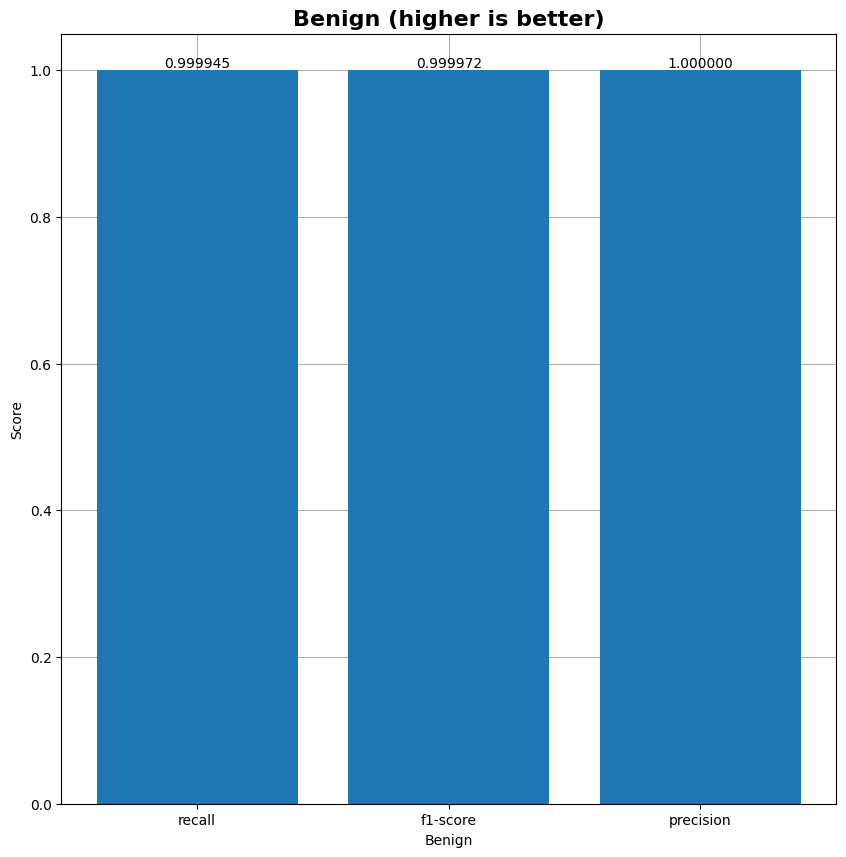

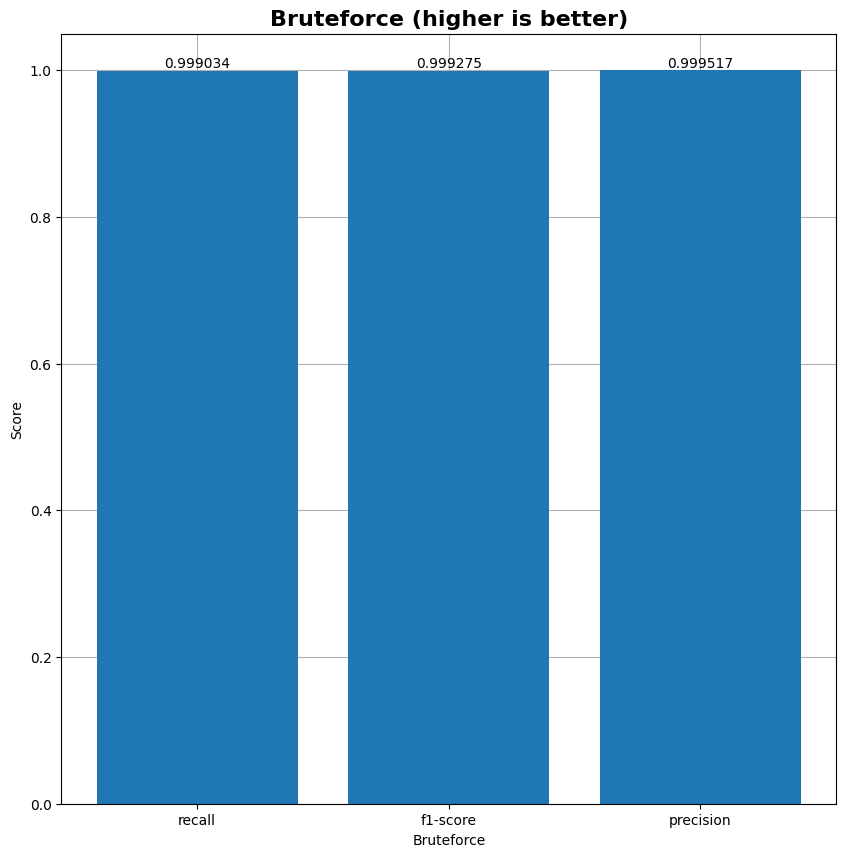

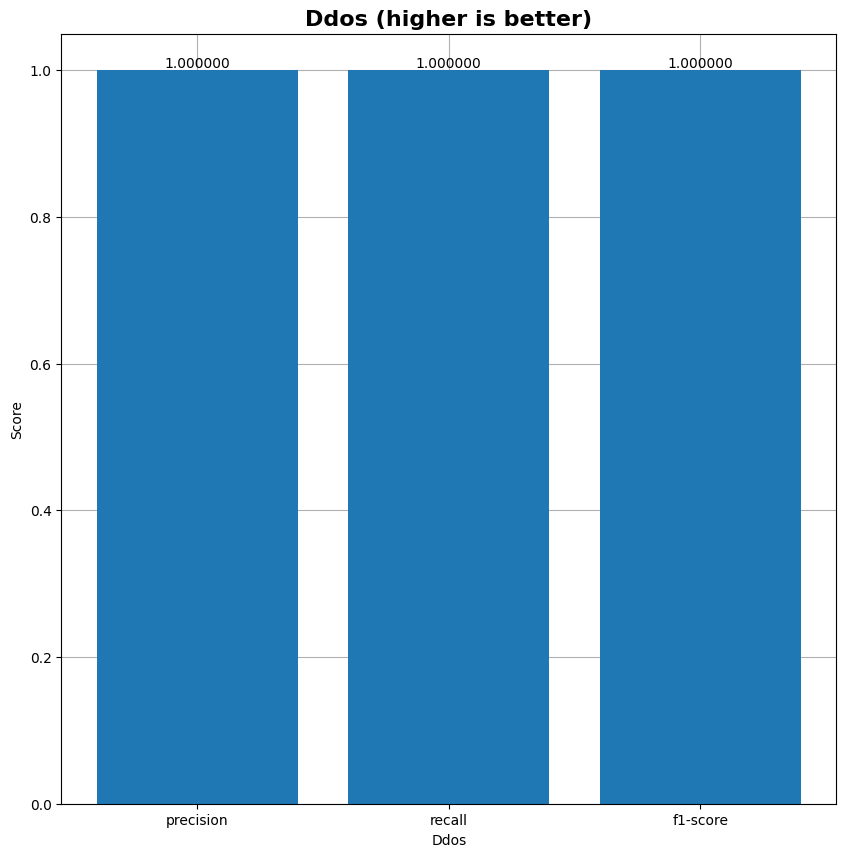

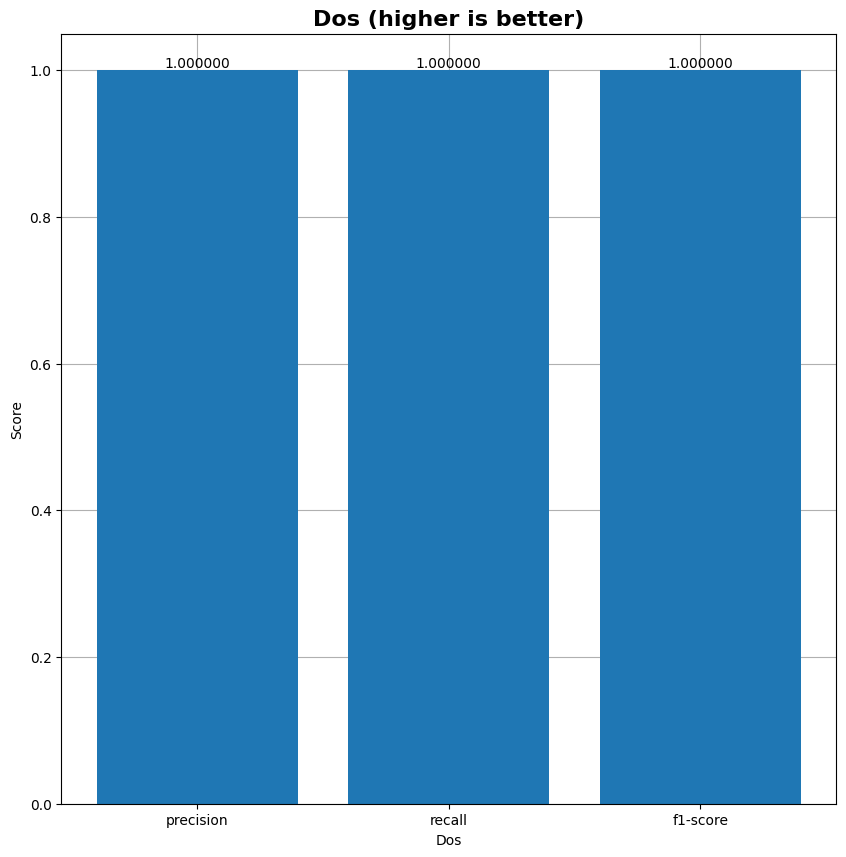

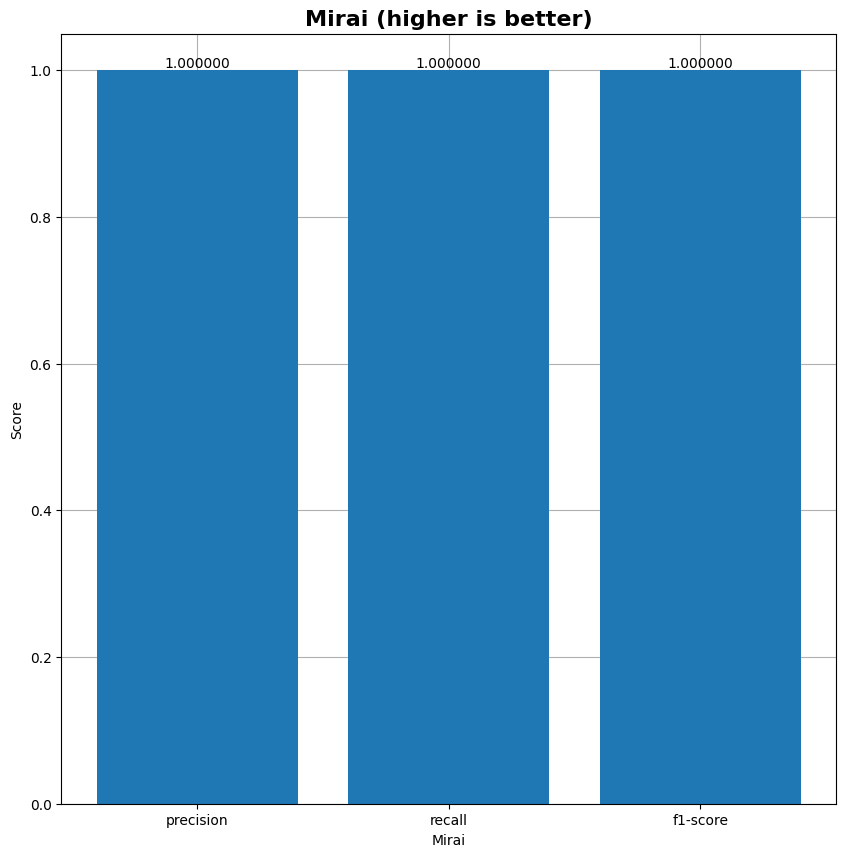

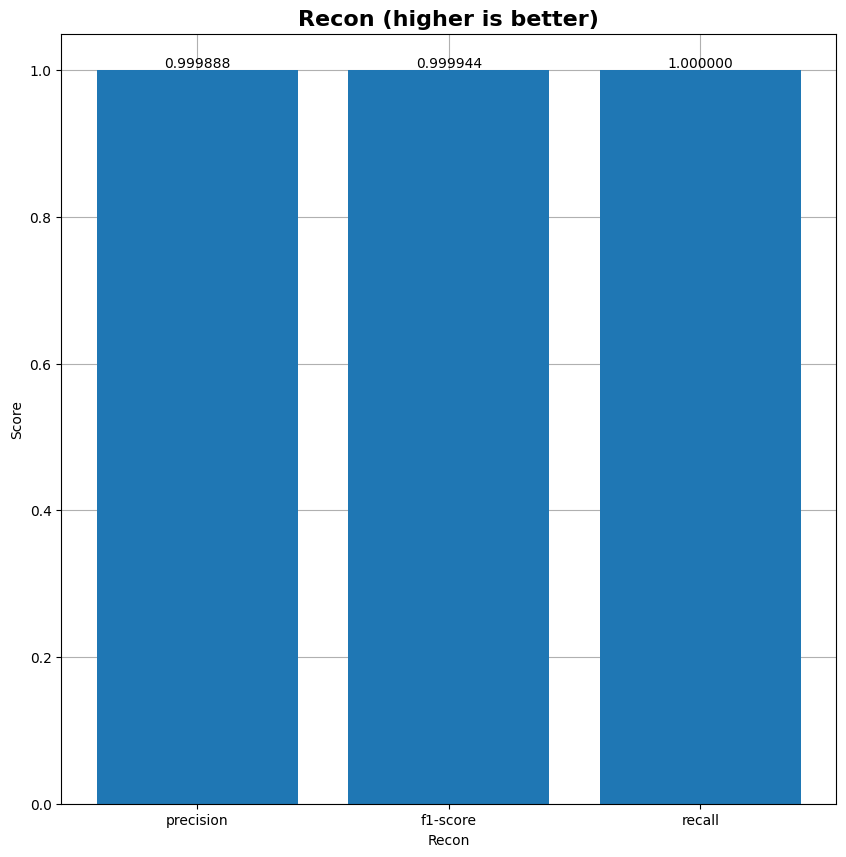

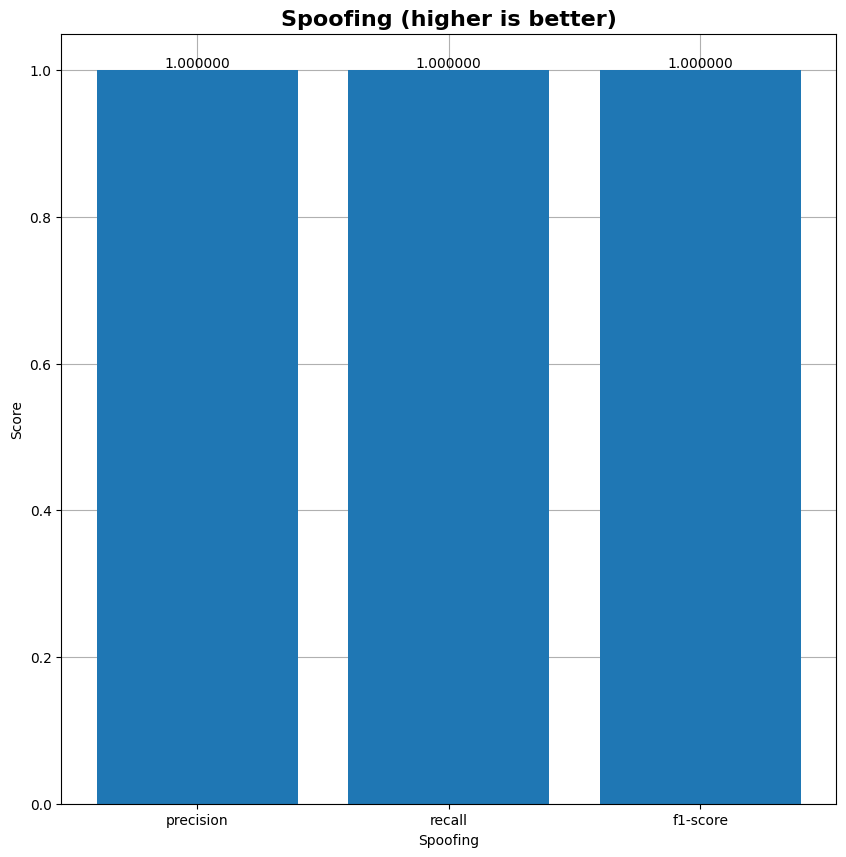

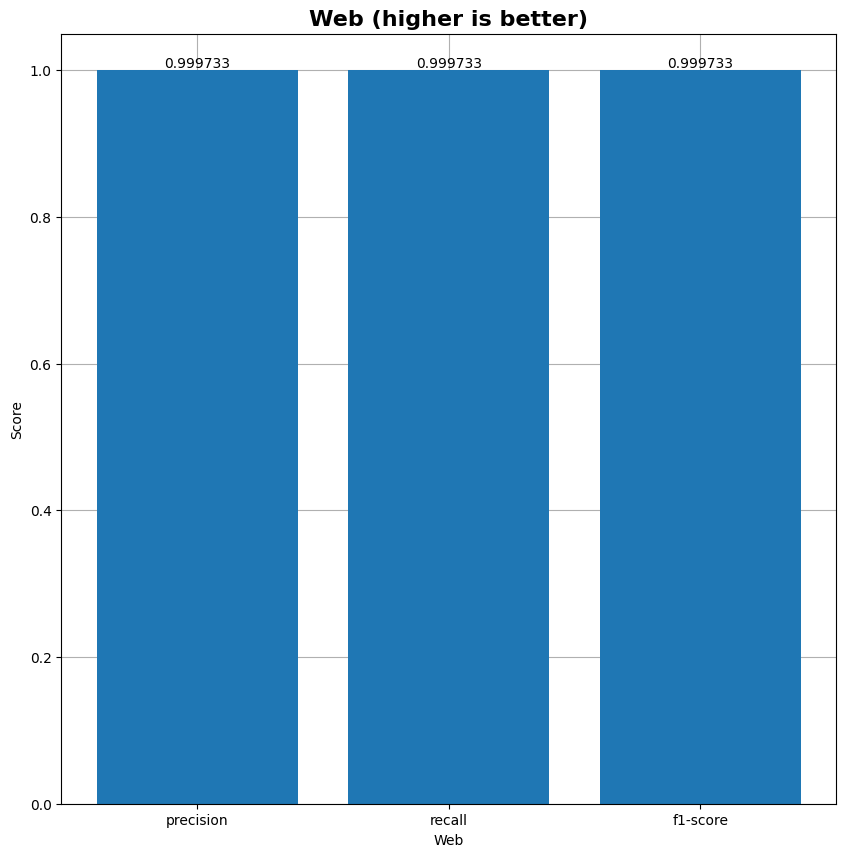

In [61]:
plot_mc(y_pred, y_test, "LSTM")

# Plot data

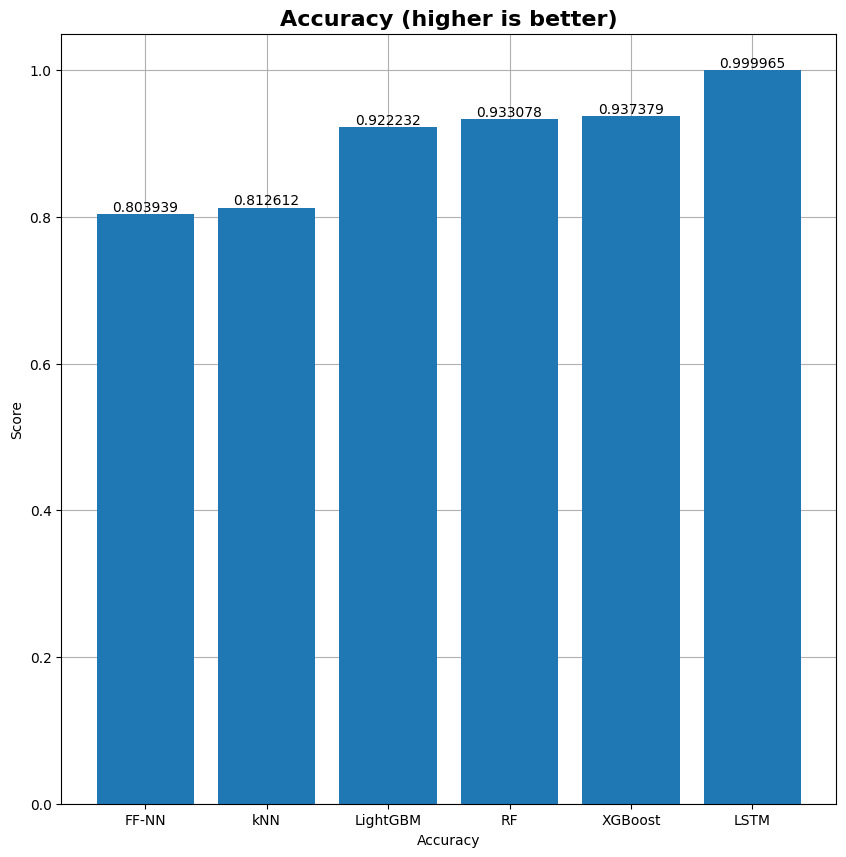

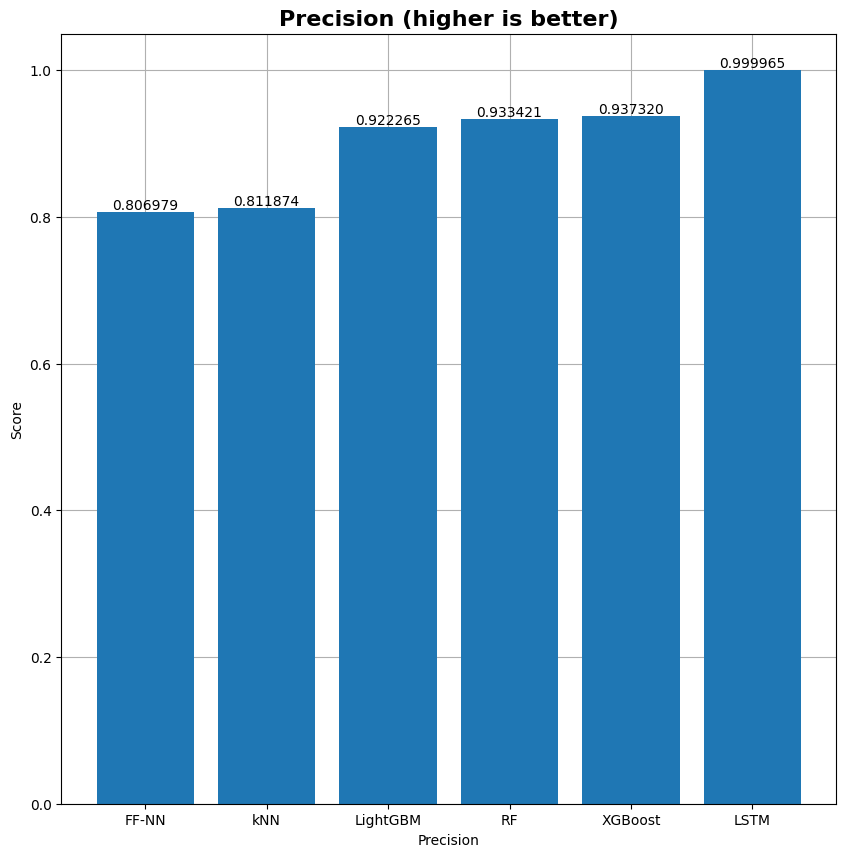

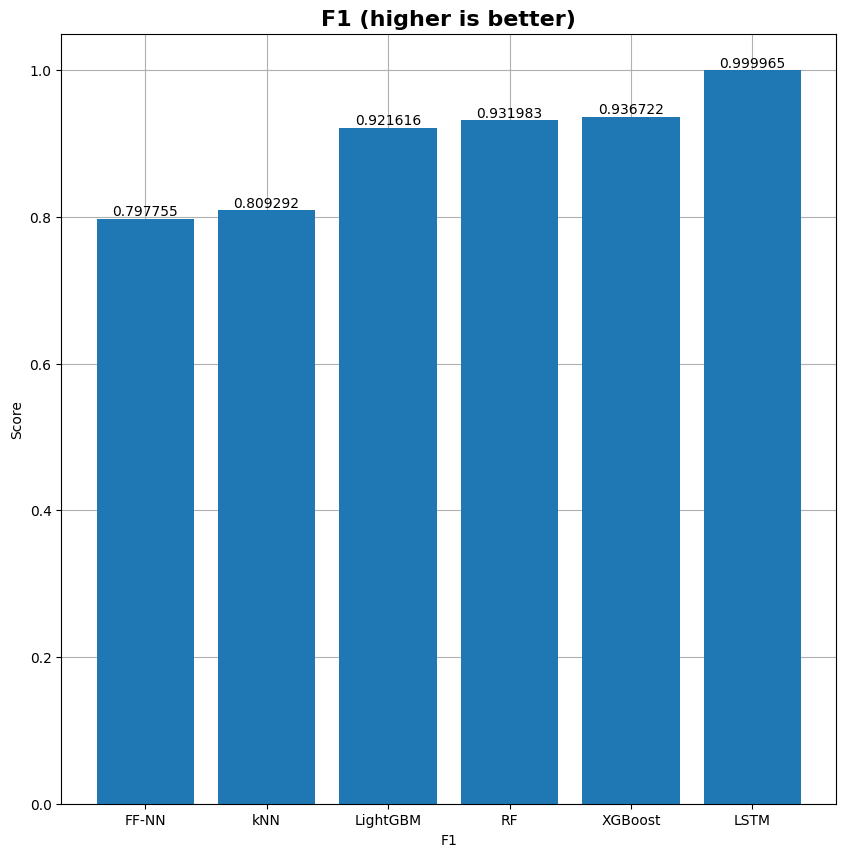

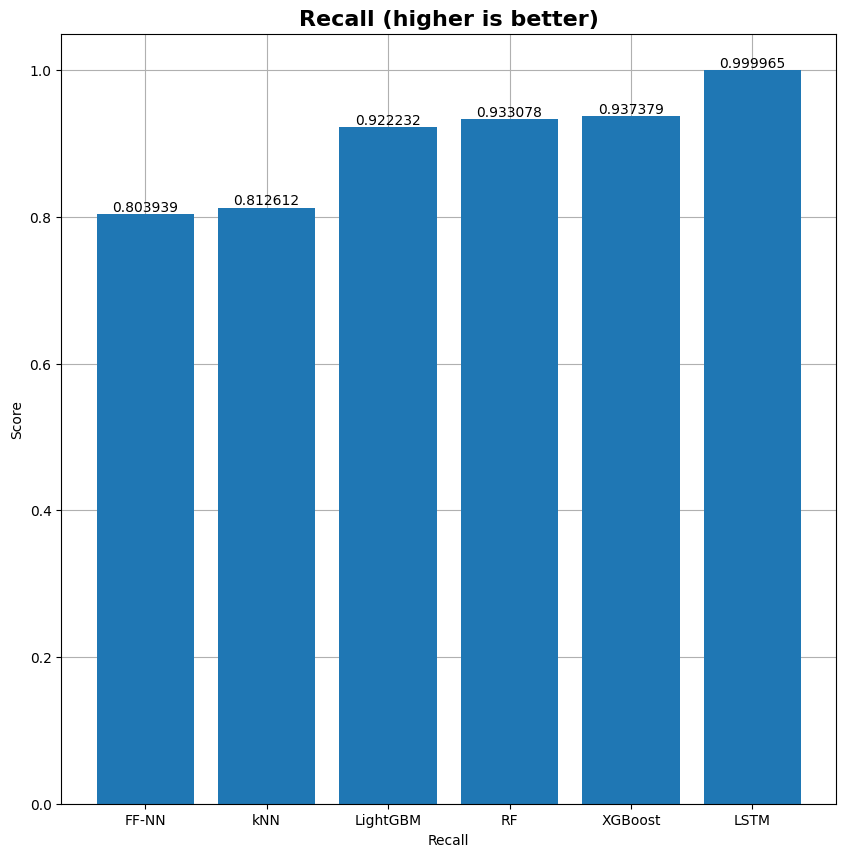

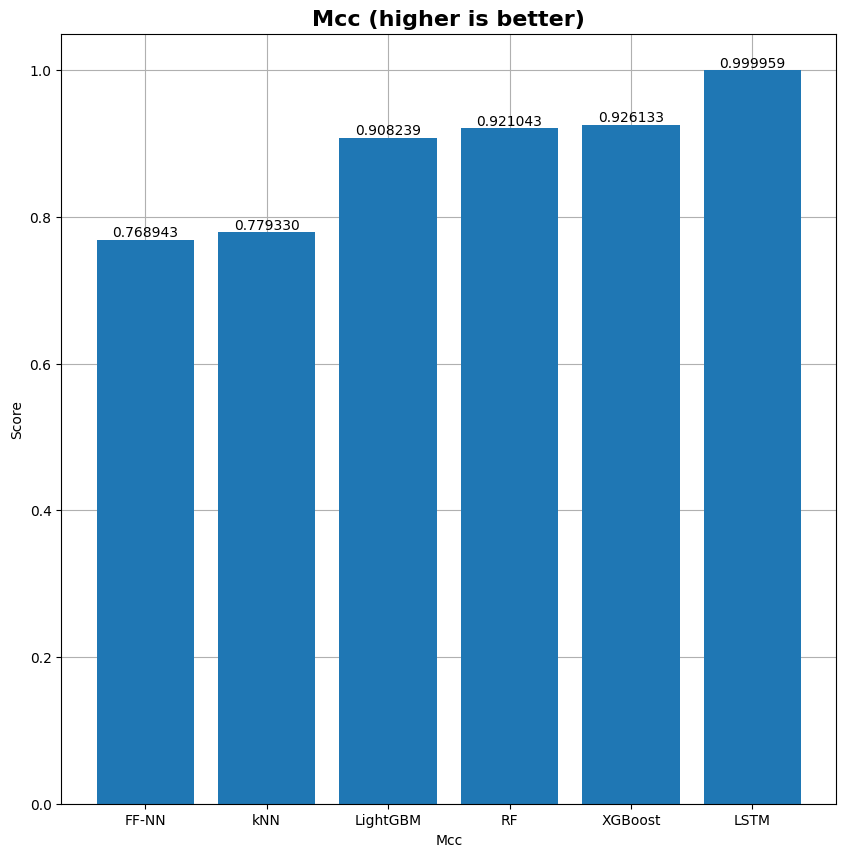

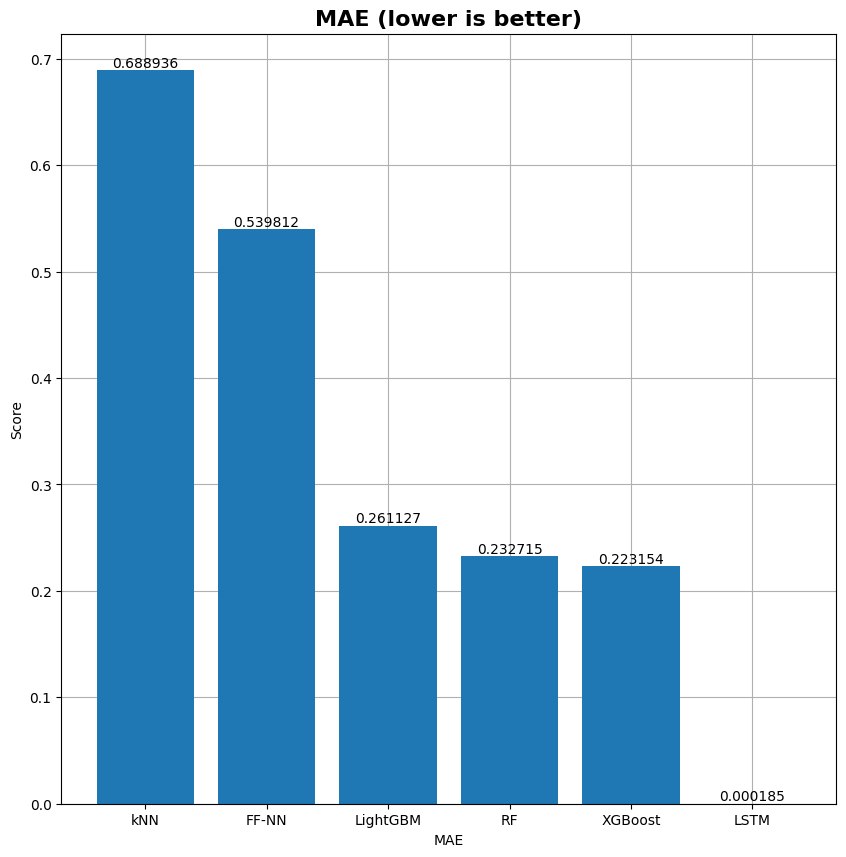

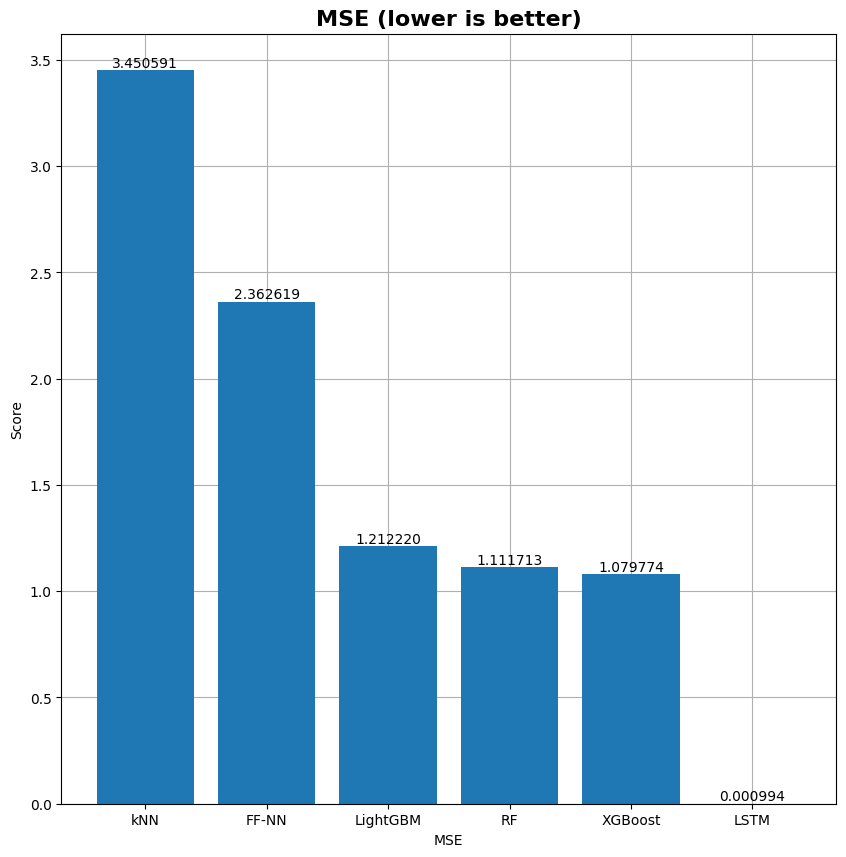

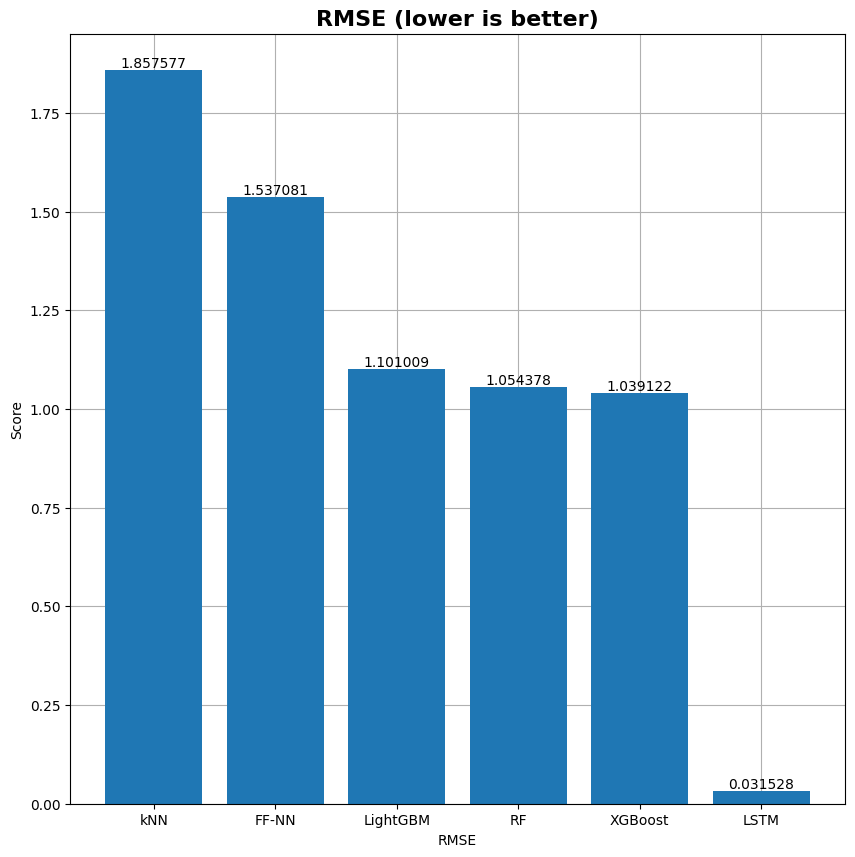

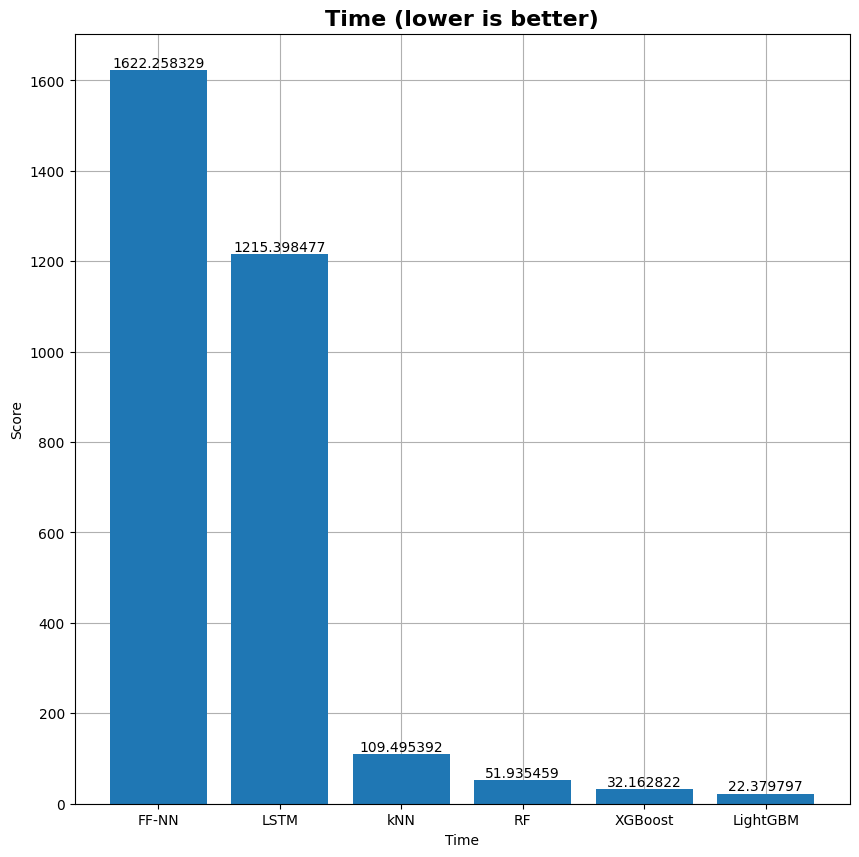

In [62]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])
for x in results_df:
    _dict = {}
    name = results_df[x].name
    for keys, values in zip(range(len(results_df[x].keys())), results_df[x]):
        _dict[results_df[x].keys()[keys]] = values
    result_plot(_dict, name, "multiclass", "")